In [1]:
import os
import numpy as np
import torch
from pathlib import Path

from model.model_vq_periodic3 import VQ_Align
from model.model_neural_transformer import NTConfig

# Configuration parameters - modify these as needed
ckpt_path = "ckpt-22.pt"  # Path to the checkpoint file
device = "cuda" if torch.cuda.is_available() else "cpu"  # Device to run inference on
output_dir = "./outputs"  # Directory to save outputs
batch_size = 1  # Batch size for inference
seed = 1337  # Random seed for reproducibility


def load_model(ckpt_path, device):
    """
    Load the VQ_Align model from checkpoint
    """
    print(f"Loading model from checkpoint: {ckpt_path}")

    # Load checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)

    # Get model configuration
    encoder_args = checkpoint['encoder_args']
    decoder_args = checkpoint['decoder_args']

    # Create model configuration
    encoder_conf = NTConfig(**encoder_args)
    decoder_conf = NTConfig(**decoder_args)

    # Initialize model
    model = VQ_Align(encoder_conf, decoder_conf)

    # Fix state dict keys if needed
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

    # Load state dict
    model.VQ.init_ae_layer()
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  # Set model to evaluation mode

    print("Model loaded successfully!")
    return model


def prepare_input(input_file, device):
    """
    Prepare input data for inference
    Note: You may need to modify this function based on your specific input format
    """
    # This is a placeholder function - modify according to your input format
    try:
        # Assuming the input is similar to what's used in training
        data = np.load(input_file)
        # Convert to tensor and move to device
        X = torch.from_numpy(data).float().to(device)

        # If your input needs specific preprocessing, add it here

        return X
    except Exception as e:
        print(f"Error loading input file: {e}")
        return None


def run_inference(model, input_data, config):
    """
    Run inference using the loaded model
    """
    print("Running inference...")

    with torch.no_grad():  # No gradient computation needed for inference
        try:
            # Based on the training script, the model might expect different inputs
            # This is a simplified version, modify as needed
            outputs = model.inference(input_data)

            # You can also visualize or analyze outputs here in notebook

            return outputs
        except Exception as e:
            print(f"Error during inference: {e}")
            return None


def save_outputs(outputs, config):
    """
    Save inference outputs
    """
    os.makedirs(config['output_dir'], exist_ok=True)
    output_path = os.path.join(config['output_dir'], 'inference_output.npy')

    try:
        # Convert outputs to numpy and save
        outputs_np = outputs.cpu().numpy()
        np.save(output_path, outputs_np)
        print(f"Outputs saved to {output_path}")

        # In a notebook, you might want to visualize the results
        # For example:
        # import matplotlib.pyplot as plt
        # plt.figure(figsize=(10, 6))
        # plt.plot(outputs_np[0])
        # plt.title("Model Output")
        # plt.show()

    except Exception as e:
        print(f"Error saving outputs: {e}")


# Main execution code - can be run cell by cell in a notebook

# Set random seed for reproducibility
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

print(f"Using device: {device}")

# Configure CUDA settings if using GPU
if 'cuda' in device:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# Load model from checkpoint
model = load_model(ckpt_path, device)
model.VQ.sigmodule_periodic_decoder_raw

Using device: cpu
Loading model from checkpoint: ckpt-22.pt


/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_65891/2697605203.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locat

{}
Final encoder config NTConfig(block_size=1024, patch_size=200, num_classes=0, in_chans=1, out_chans=16, use_mean_pooling=True, init_scale=0.001, n_layer=12, n_head=12, n_embd=768, dropout=0.1, bias=False)
Final decoder config NTConfig(block_size=1024, patch_size=200, num_classes=0, in_chans=128, out_chans=16, use_mean_pooling=True, init_scale=0.001, n_layer=4, n_head=12, n_embd=768, dropout=0.1, bias=False)
Model loaded successfully!


PeriodicTransformerDecoder(
  (input_proj): Linear(in_features=200, out_features=384, bias=True)
  (layers): ModuleList(
    (0-3): 4 x PeriodicTransformerLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
      )
      (amp_ffn): AMPFeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): SnakeActivation()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=1536, out_features=384, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (low_pass): LowPassFilter()
        (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (freq_extractors): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=384, out_features=192, bias=True)
      (1): SnakeActivation()
      (2): Linea

## Eval/inference VQ

In [2]:

from dataset import PickleLoader
data_dir = 'tuh'
files = Path(data_dir).rglob('*.pkl')
files = [file for file in files][:10000]
dataset1 = PickleLoader(files)

data_loader1 = torch.utils.data.DataLoader(
    dataset1,
    batch_size=1,
    num_workers=10,
    pin_memory=True,
    drop_last=True,
    shuffle=True
)


data_dir = 'thinking-out-loud/'
files = Path(data_dir).rglob('*.pkl')
files = [file for file in files][:10000]
dataset2 = PickleLoader(files)

data_loader2 = torch.utils.data.DataLoader(
    dataset2,
    batch_size=1,
    num_workers=10,
    pin_memory=True,
    drop_last=True,
    shuffle=True
)



In [9]:
for v in model.VQ.sigmodule_periodic_decoder_raw.parameters():
    print((v==0).float().mean())

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [3]:
# """
# EEG Reconstruction Visualization Script for NeuroLM VQ Model
# """

# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas as pd
# from pathlib import Path
# from dataset import PickleLoader
# from model.model_vq import VQ_Align
# from model.model_neural_transformer import NTConfig

# # Configuration
# device = "cuda" if torch.cuda.is_available() else "cpu"
# num_channels = 23  # Number of EEG channels

# def load_model(ckpt_path, device):
#     """Load the VQ model from checkpoint"""
#     print(f"Loading model from checkpoint: {ckpt_path}")
    
#     # Load checkpoint
#     checkpoint = torch.load(ckpt_path, map_location=device)
    
#     # Get model configuration
#     encoder_args = checkpoint['encoder_args']
#     decoder_args = checkpoint['decoder_args']
    
#     # Create model configuration
#     encoder_conf = NTConfig(**encoder_args)
#     decoder_conf = NTConfig(**decoder_args)
    
#     # Initialize model
#     model = VQ_Align(encoder_conf, decoder_conf)
    
#     # Fix state dict keys if needed
#     state_dict = checkpoint['model']
#     unwanted_prefix = '_orig_mod.'
#     for k, v in list(state_dict.items()):
#         if k.startswith(unwanted_prefix):
#             state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    
#     # Filter out unwanted keys that might be in the checkpoint but not in the model
#     state_dict = {k: v for k, v in state_dict.items() if k not in [
#         "domain_classifier.0.weight", "domain_classifier.0.bias", 
#         "domain_classifier.2.weight", "domain_classifier.2.bias", 
#         "wte.weight", "VQ.quantize.cluster_size", 
#         "VQ.quantize.embedding.weight", "VQ.quantize.embedding.cluster_size", 
#         "VQ.quantize.embedding.embed_avg", "VQ.quantize.embedding.initted"
#     ]}
    
#     # Load state dict
#     model.load_state_dict(state_dict)
#     model.to(device)
#     model.eval()  # Set to evaluation mode
    
#     return model

# def visualize_channel_reconstructions_matplotlib(X, xrec_raw, xrec_freq, num_channels=23, channels_to_show=None):
#     """
#     Visualize reconstructions for selected channels using Matplotlib
#     ```
    
#     Args:
#         X: Input EEG data [batch, channels, time]
#         xrec_raw: Raw domain reconstruction
#         xrec_freq: Frequency domain reconstruction
#         num_channels: Total number of channels
#         channels_to_show: List of channel indices to display (None = all)
#     """
#     if channels_to_show is None:
#         channels_to_show = range(min(6, num_channels))  # Show first 6 channels by default
    
#     # Convert to numpy
#     X_np = X[0].cpu().numpy()  # First batch
#     xrec_raw_np = xrec_raw[0].cpu().numpy()
    
#     # Squeeze dimensions if needed
#     X_np = X_np.squeeze()
#     stop = X_np.shape[0] - X_np.shape[0] % num_channels
    
#     # Create a single column of larger plots for each channel
#     n_rows = len(channels_to_show)
#     fig, axs = plt.subplots(n_rows, 1, figsize=(16, 6
#                                                 * n_rows))
    
#     if n_rows == 1:
#         axs = [axs]  # Make iterable for single channel case
    
#     for i, ch_idx in enumerate(channels_to_show):
#         # Extract channel data
#         original_signal = X_np[ch_idx:stop:num_channels, :].flatten()
#         raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()

#         # Normalize signals for better comparison
#         original_signal = original_signal/((original_signal**2).sum())**0.5
#         raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
#         # Time domain plot with larger size
#         ax = axs[i]
#         ax.plot(original_signal, 'b-', label='Original', alpha=0.7, linewidth=1.5)
#         ax.plot(raw_recon, 'r-', label='Reconstruction', alpha=0.7, linewidth=1.5)
#         ax.set_title(f'Channel {ch_idx+1} - EEG Signal Reconstruction', fontsize=14)
#         ax.set_xlabel('Sample', fontsize=12)
#         ax.set_ylabel('Amplitude', fontsize=12)
#         ax.legend(fontsize=12)
#         ax.grid(True, alpha=0.3)
        
#         # Add a zoom-in view of a segment for detailed comparison
#         segment_length = min(500, len(original_signal))
#         segment_start = len(original_signal) // 3  # Start from 1/3 of the signal
        
#         # Create an inset axes for the zoomed view
#         axins = ax.inset_axes([0.6, 0.6, 0.35, 0.3])
#         axins.plot(original_signal[segment_start:segment_start+segment_length], 'b-', linewidth=1.5)
#         axins.plot(raw_recon[segment_start:segment_start+segment_length], 'r-', linewidth=1.5)
#         axins.set_title('Zoomed Detail', fontsize=10)
#         axins.grid(True, alpha=0.3)
        
#         # Add connecting lines to show the zoomed region
#         ax.indicate_inset_zoom(axins, edgecolor="black")
    
#     plt.tight_layout()
#     plt.show()
    
#     # Create error visualization
#     fig, axs = plt.subplots(n_rows, 1, figsize=(16, 4 * n_rows))
    
#     if n_rows == 1:
#         axs = [axs]  # Make iterable for single channel case
    
#     for i, ch_idx in enumerate(channels_to_show):
#         # Extract channel data
#         original_signal = X_np[ch_idx:stop:num_channels, :].flatten()#[:600] 
#         raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()#[:600]
#         # batch    
#         # Normalize signals
#         original_signal = original_signal/((original_signal**2).sum())**0.5
#         raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
#         # Compute error
#         raw_error = original_signal - raw_recon
        
#         # Error plot
#         ax = axs[i]
#         ax.plot(raw_error, 'r-', alpha=0.7, linewidth=1.5)
#         ax.set_title(f'Channel {ch_idx+1} - Reconstruction Error', fontsize=14)
#         ax.set_xlabel('Sample', fontsize=12)
#         ax.set_ylabel('Error Amplitude', fontsize=12)
#         ax.grid(True, alpha=0.3)
        
#         # Add horizontal lines at zero
#         ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        
#         # Add error statistics as text
#         mse = np.mean(raw_error**2)
#         mae = np.mean(np.abs(raw_error))
#         ax.text(0.02, 0.95, f'MSE: {mse:.6f}\nMAE: {mae:.6f}', 
#                 transform=ax.transAxes, fontsize=12,
#                 bbox=dict(facecolor='white', alpha=0.8))
    
#     plt.tight_layout()
#     plt.show()

#     # Create heatmap showing reconstruction quality across all channels
#     fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
#     # Prepare data for heatmap
#     all_channels_raw_error = []
    
#     for ch_idx in range(num_channels):
#         # Extract channel data
#         original_signal = X_np[ch_idx:stop:num_channels, :].flatten()
#         raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()
        
#         # Normalize signals
#         original_signal = original_signal/((original_signal**2).sum())**0.5
#         raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
#         # Compute mean squared error
#         raw_mse = np.mean((original_signal - raw_recon)**2)
#         all_channels_raw_error.append(raw_mse)
    
#     # Create heatmap
#     im = ax.imshow(np.array(all_channels_raw_error).reshape(-1, 1), aspect='auto', cmap='viridis_r')
#     ax.set_title('Reconstruction MSE by Channel', fontsize=16)
#     ax.set_xlabel('MSE', fontsize=14)
#     ax.set_ylabel('Channel', fontsize=14)
#     ax.set_yticks(range(num_channels))
#     ax.set_yticklabels([f'Ch {i+1}' for i in range(num_channels)])
#     plt.colorbar(im, ax=ax)
    
#     plt.tight_layout()
#     plt.show()

# # Main execution functions
# def process_batch(model, batch, device, return_reconstruction=True):
#     """Process a batch of EEG data through the model"""
#     X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
#     X = X.float().to(device, non_blocking=True)
#     Y_freq = Y_freq.float().to(device, non_blocking=True)
#     Y_raw = Y_raw.float().to(device, non_blocking=True)
#     input_chans = input_chans.to(device, non_blocking=True)
#     input_time = input_time.to(device, non_blocking=True)
#     input_mask = input_mask.to(device, non_blocking=True)
    
#     with torch.no_grad():
#         if return_reconstruction:
#             (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
#                 X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
#                 return_reconstruction=True
#             )
#         else:
#             loss, encoder_features, log = model.VQ(
#                 X, Y_freq, Y_raw, input_chans, input_time, input_mask
#             )
#             xrec_freq, xrec_raw = None, None
    
#     return X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log

# def analyze_eeg_reconstructions(model, data_loader, device, num_channels=23, num_batches=5):
#     """
#     Perform comprehensive analysis of EEG reconstructions
    
#     Args:
#         model: The trained VQ_Align model
#         data_loader: DataLoader with EEG samples
#         device: Device to run inference on
#         num_channels: Number of EEG channels
#         num_batches: Number of batches to analyze
#     """
#     model.eval()  # Set model to evaluation mode
    
#     all_metrics = []
    
#     for batch_idx, batch in enumerate(data_loader):
#         if batch_idx >= num_batches:
#             break
        
#         print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
        
#         # Process batch
#         X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
#             model, batch, device
#         )
        
#         print(f"Input shape: {X.shape}")
#         print(f"Raw reconstruction shape: {xrec_raw.shape}")
#         print(f"Freq reconstruction shape: {xrec_freq.shape}")
        
#         # Visualize channel reconstructions with Matplotlib
#         print("\nGenerating Matplotlib visualizations...")
#         freq, raw = model.VQ.decode(quantize,input_chans, input_time)
#         visualize_channel_reconstructions_matplotlib(X, xrec_raw, xrec_freq, num_channels=num_channels)
 
#         # 4. Evaluate reconstruction quality
#         print("\nEvaluating reconstruction quality...")
#         metrics = evaluate_reconstruction_quality(X, xrec_raw, xrec_freq, num_channels=num_channels)
#         metrics['batch_idx'] = batch_idx
#         all_metrics.append(metrics)
        
#         print(f"Completed analysis for batch {batch_idx+1}")
    
#     # Combine metrics from all batches
#     if all_metrics:
#         combined_metrics = pd.concat(all_metrics)
        
#         # Aggregate results across batches
#         print("\n=== Overall Reconstruction Quality (All Batches) ===")
#         print(f"Average Raw Correlation: {combined_metrics['Raw_Correlation'].mean():.4f}")
#         print(f"Average Freq Correlation: {combined_metrics['Freq_Correlation'].mean():.4f}")
#         print(f"Average Raw MSE: {combined_metrics['Raw_MSE'].mean():.4e}")
#         print(f"Average Freq MSE: {combined_metrics['Freq_MSE'].mean():.4e}")
        
#         return combined_metrics
    
#     return None

# # Main execution

# from dataset import PickleLoader
# # data_dir = '/workspace/tuh_full'
# # files = Path(data_dir).rglob('*.pkl')
# # files = [file for file in files][:10]
# # dataset1 = PickleLoader(files)

# # data_loader1 = torch.utils.data.DataLoader(
# #     dataset1,
# #     batch_size=1,
# #     num_workers=10,
# #     pin_memory=True,
# #     drop_last=True,
# #     shuffle=True
# # )


# # data_dir = '/workspace/NeuroLM-Decode/pkl_data_2/'
# # files = Path(data_dir).rglob('*.pkl')
# # files = [file for file in files][:10]
# # dataset2 = PickleLoader(files)

# # data_loader2 = torch.utils.data.DataLoader(
# #     dataset2,
# #     batch_size=1,
# #     num_workers=10,
# #     pin_memory=True,
# #     drop_last=True,
# #     shuffle=True
# # )

/Users/adamsobieszek/PycharmProjects/NeuroLM-Decode/model/model_vq_periodic3.py:229: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


tensor([0.1192]) tensor([[[1.9573, 1.7526, 1.8781,  ..., 2.9314, 2.4358, 1.2528],
         [1.3500, 1.1735, 1.2622,  ..., 3.4792, 2.9822, 1.8970],
         [2.0184, 1.8183, 1.9473,  ..., 2.5126, 2.0563, 0.9289],
         ...,
         [1.1072, 0.9124, 1.0436,  ..., 3.7251, 3.2308, 2.0817],
         [1.1081, 0.9133, 1.0445,  ..., 3.7243, 3.2300, 2.0809],
         [1.1065, 0.9118, 1.0431,  ..., 3.7238, 3.2297, 2.0808]]])
Input shape: torch.Size([1, 1024, 200])
Raw reconstruction shape: torch.Size([1, 1024, 200])
Freq reconstruction shape: torch.Size([1, 1024, 100])

Generating Matplotlib visualizations...


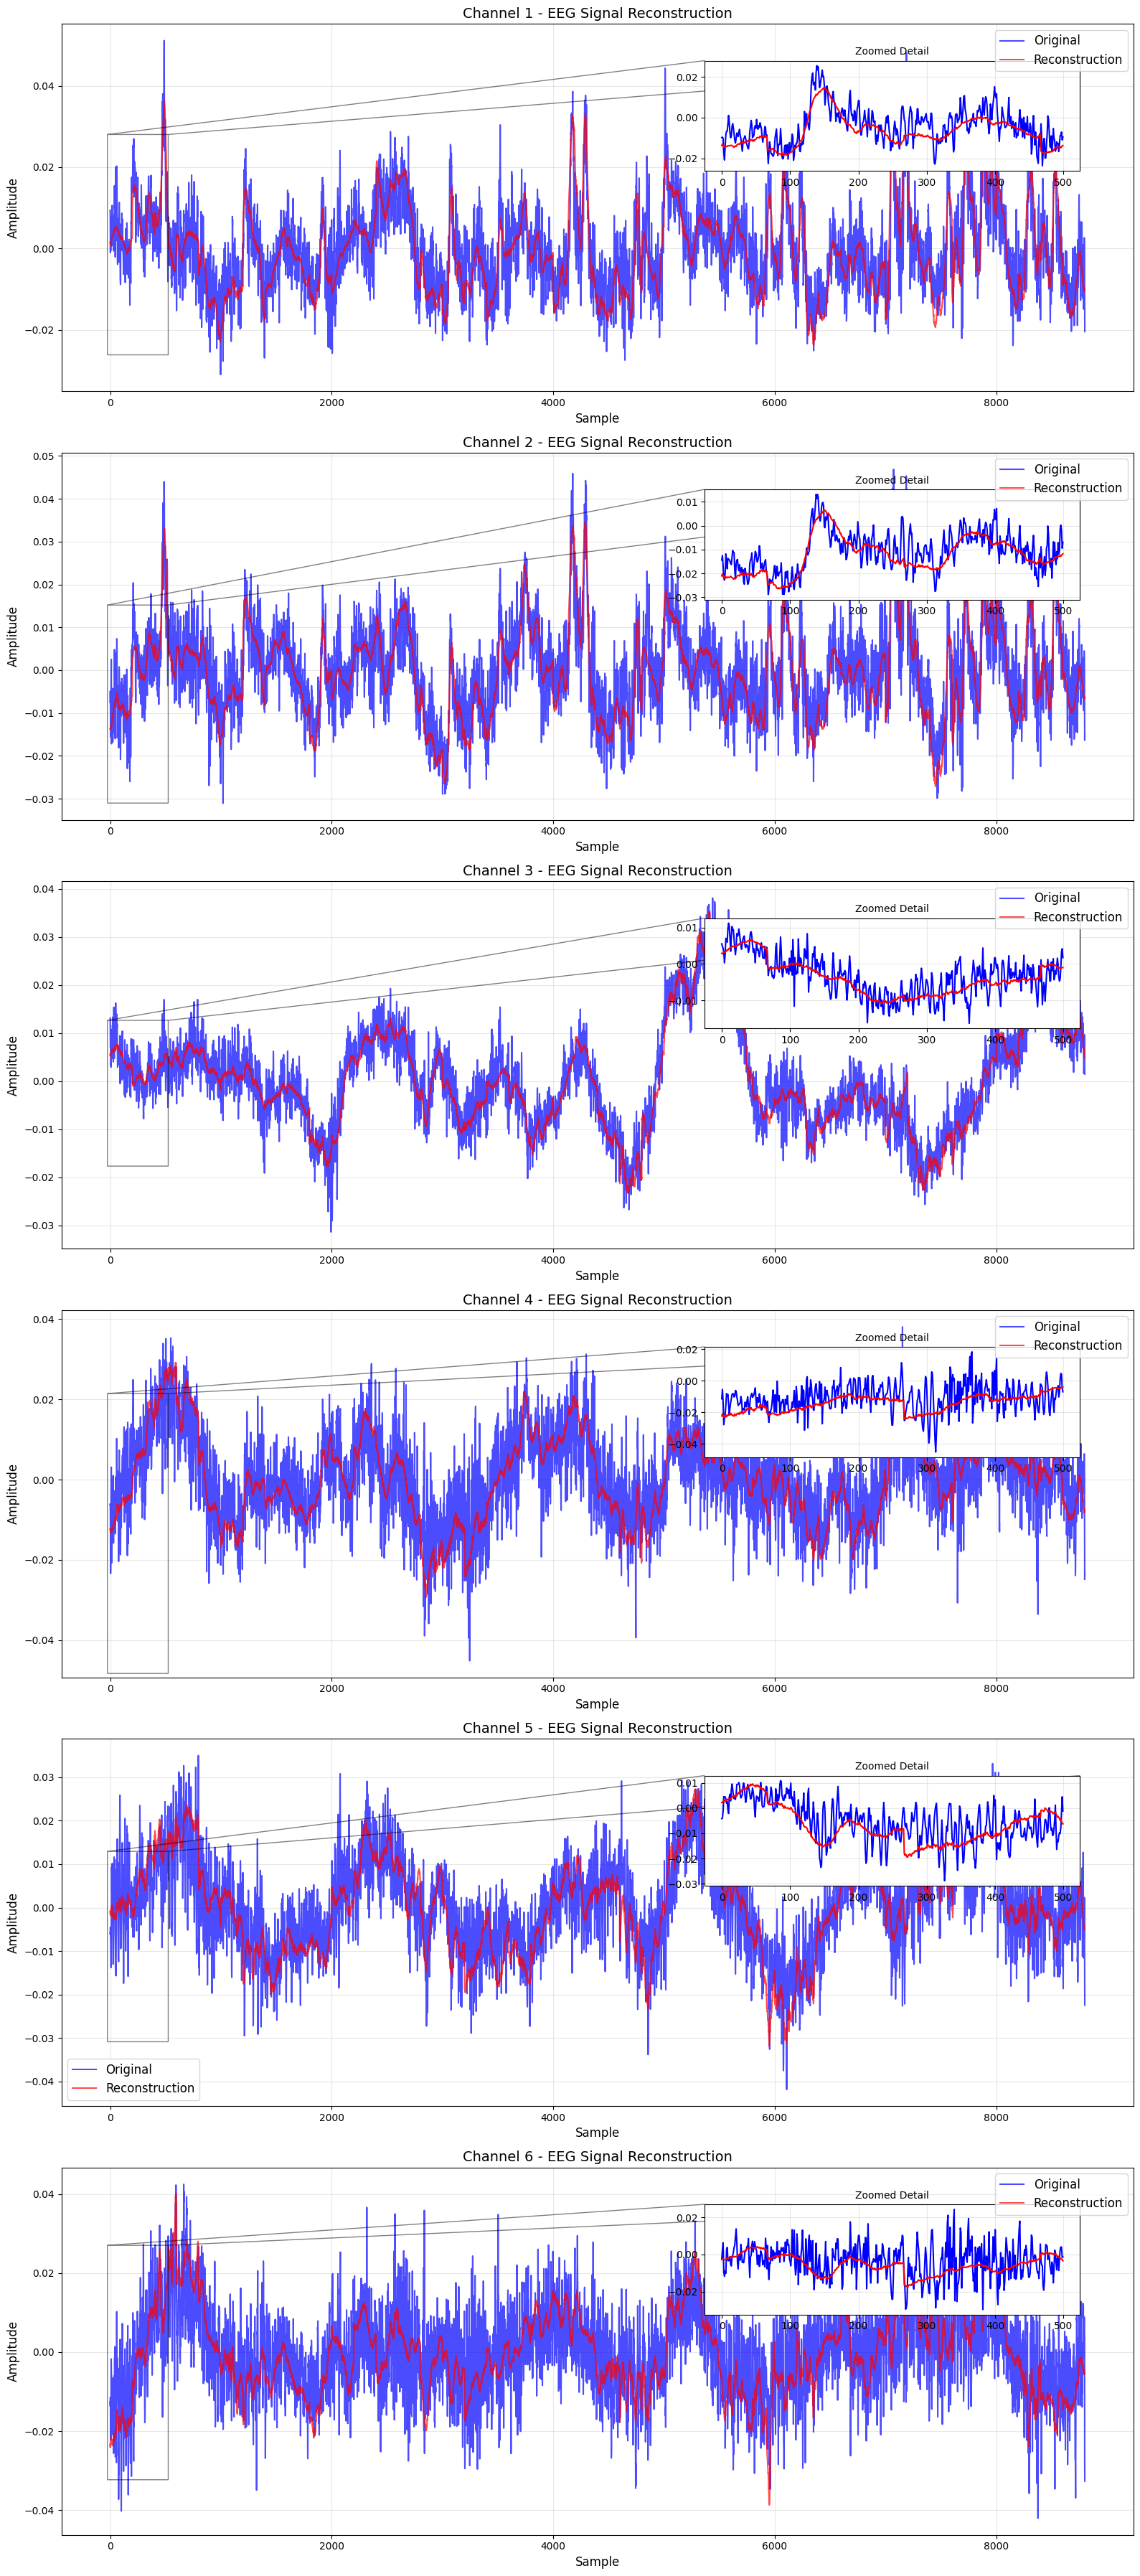

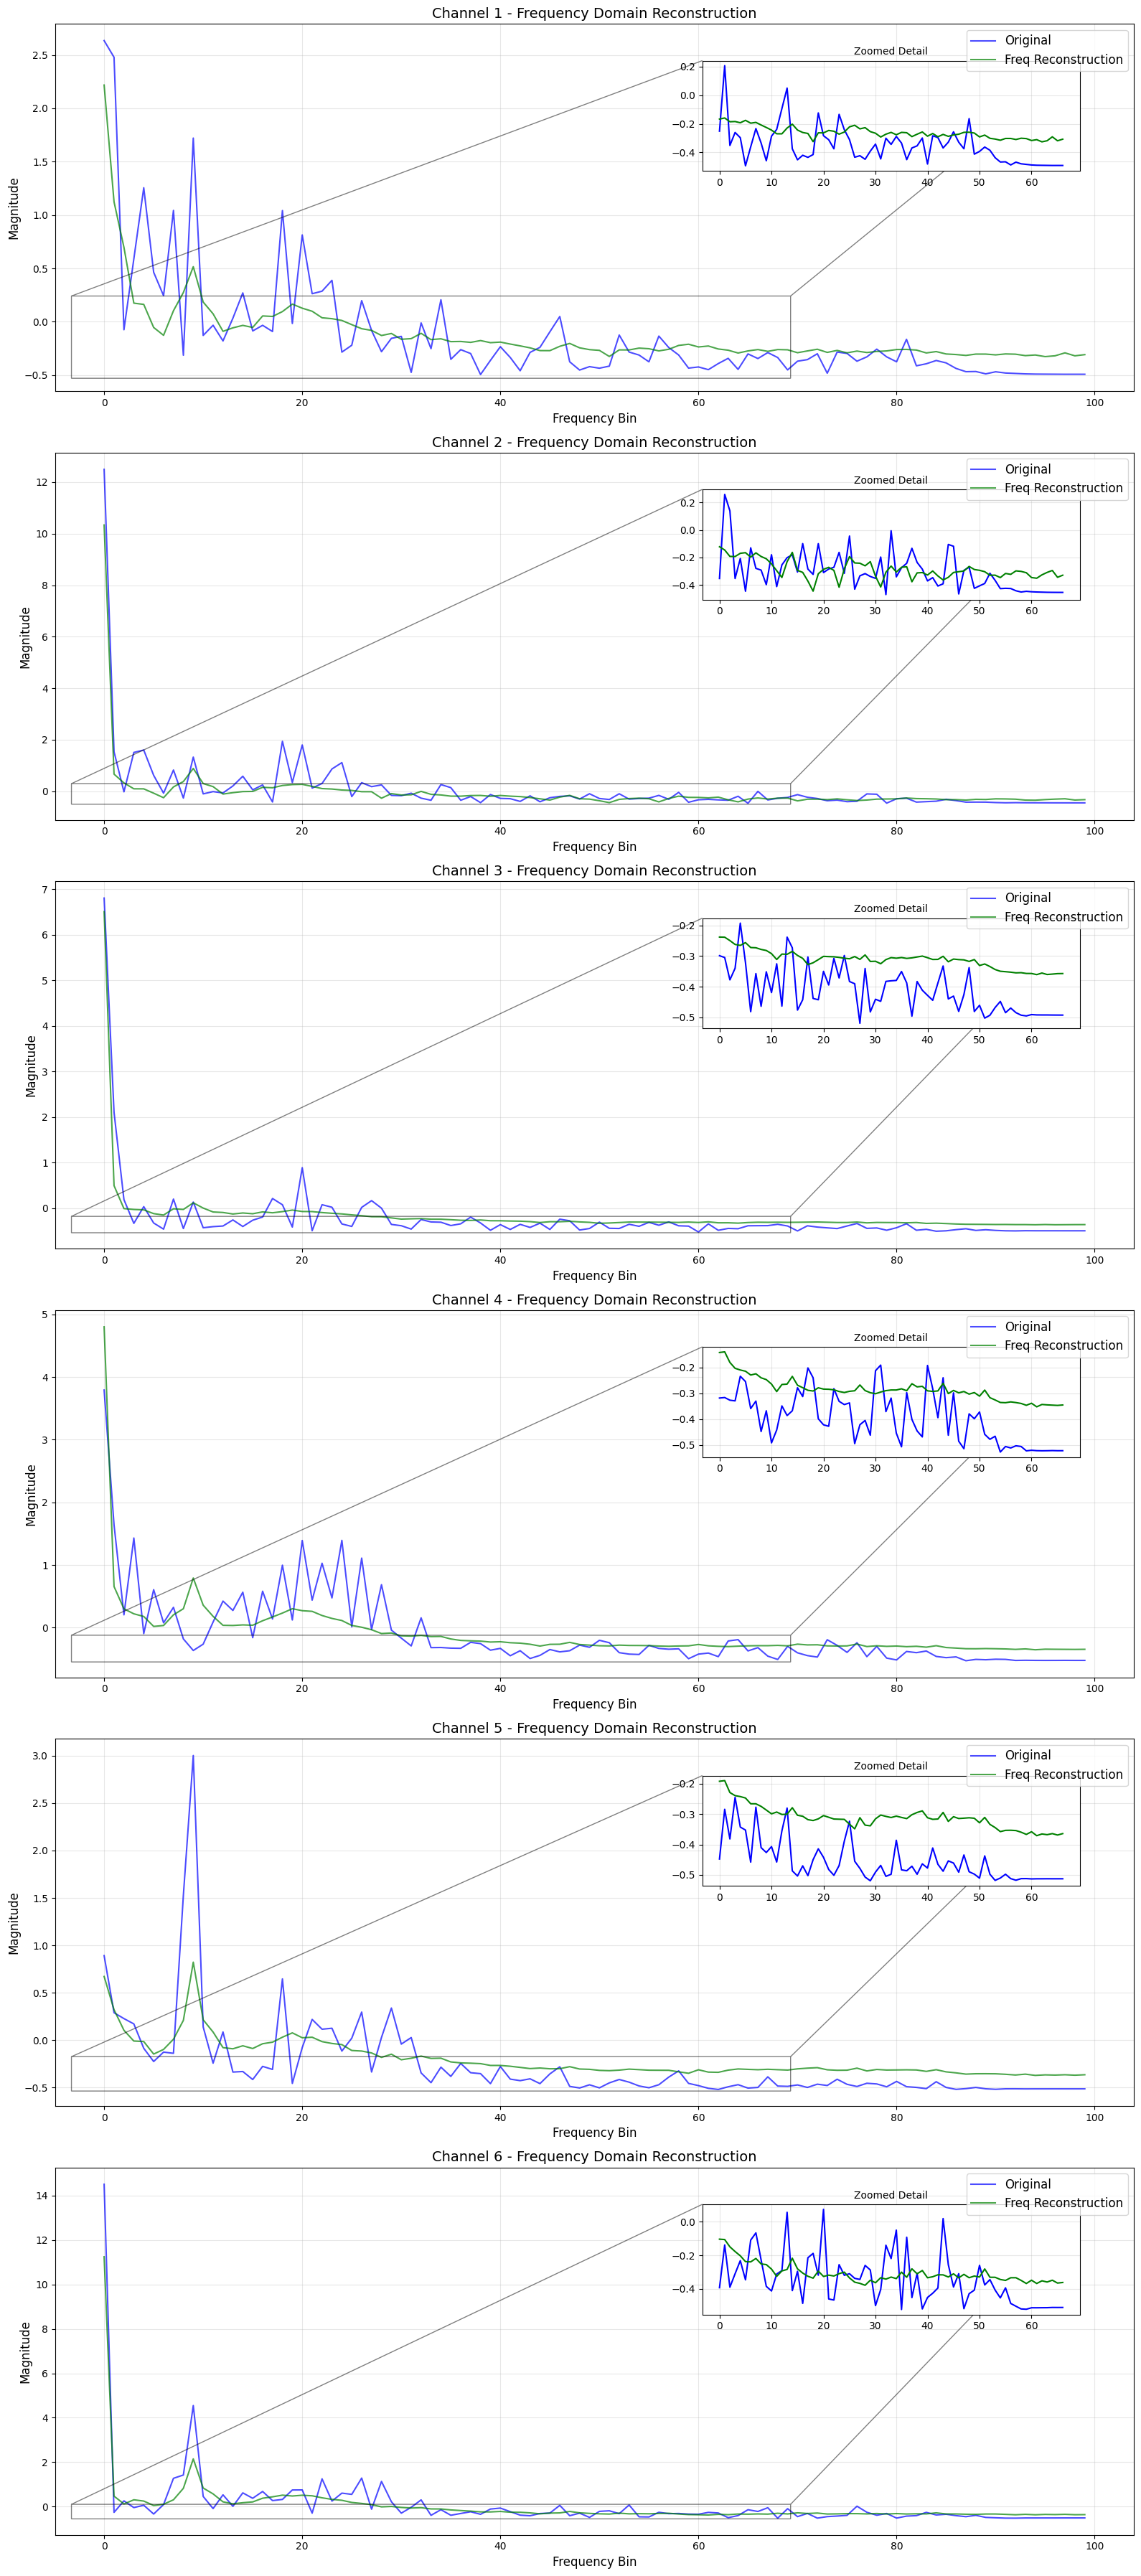

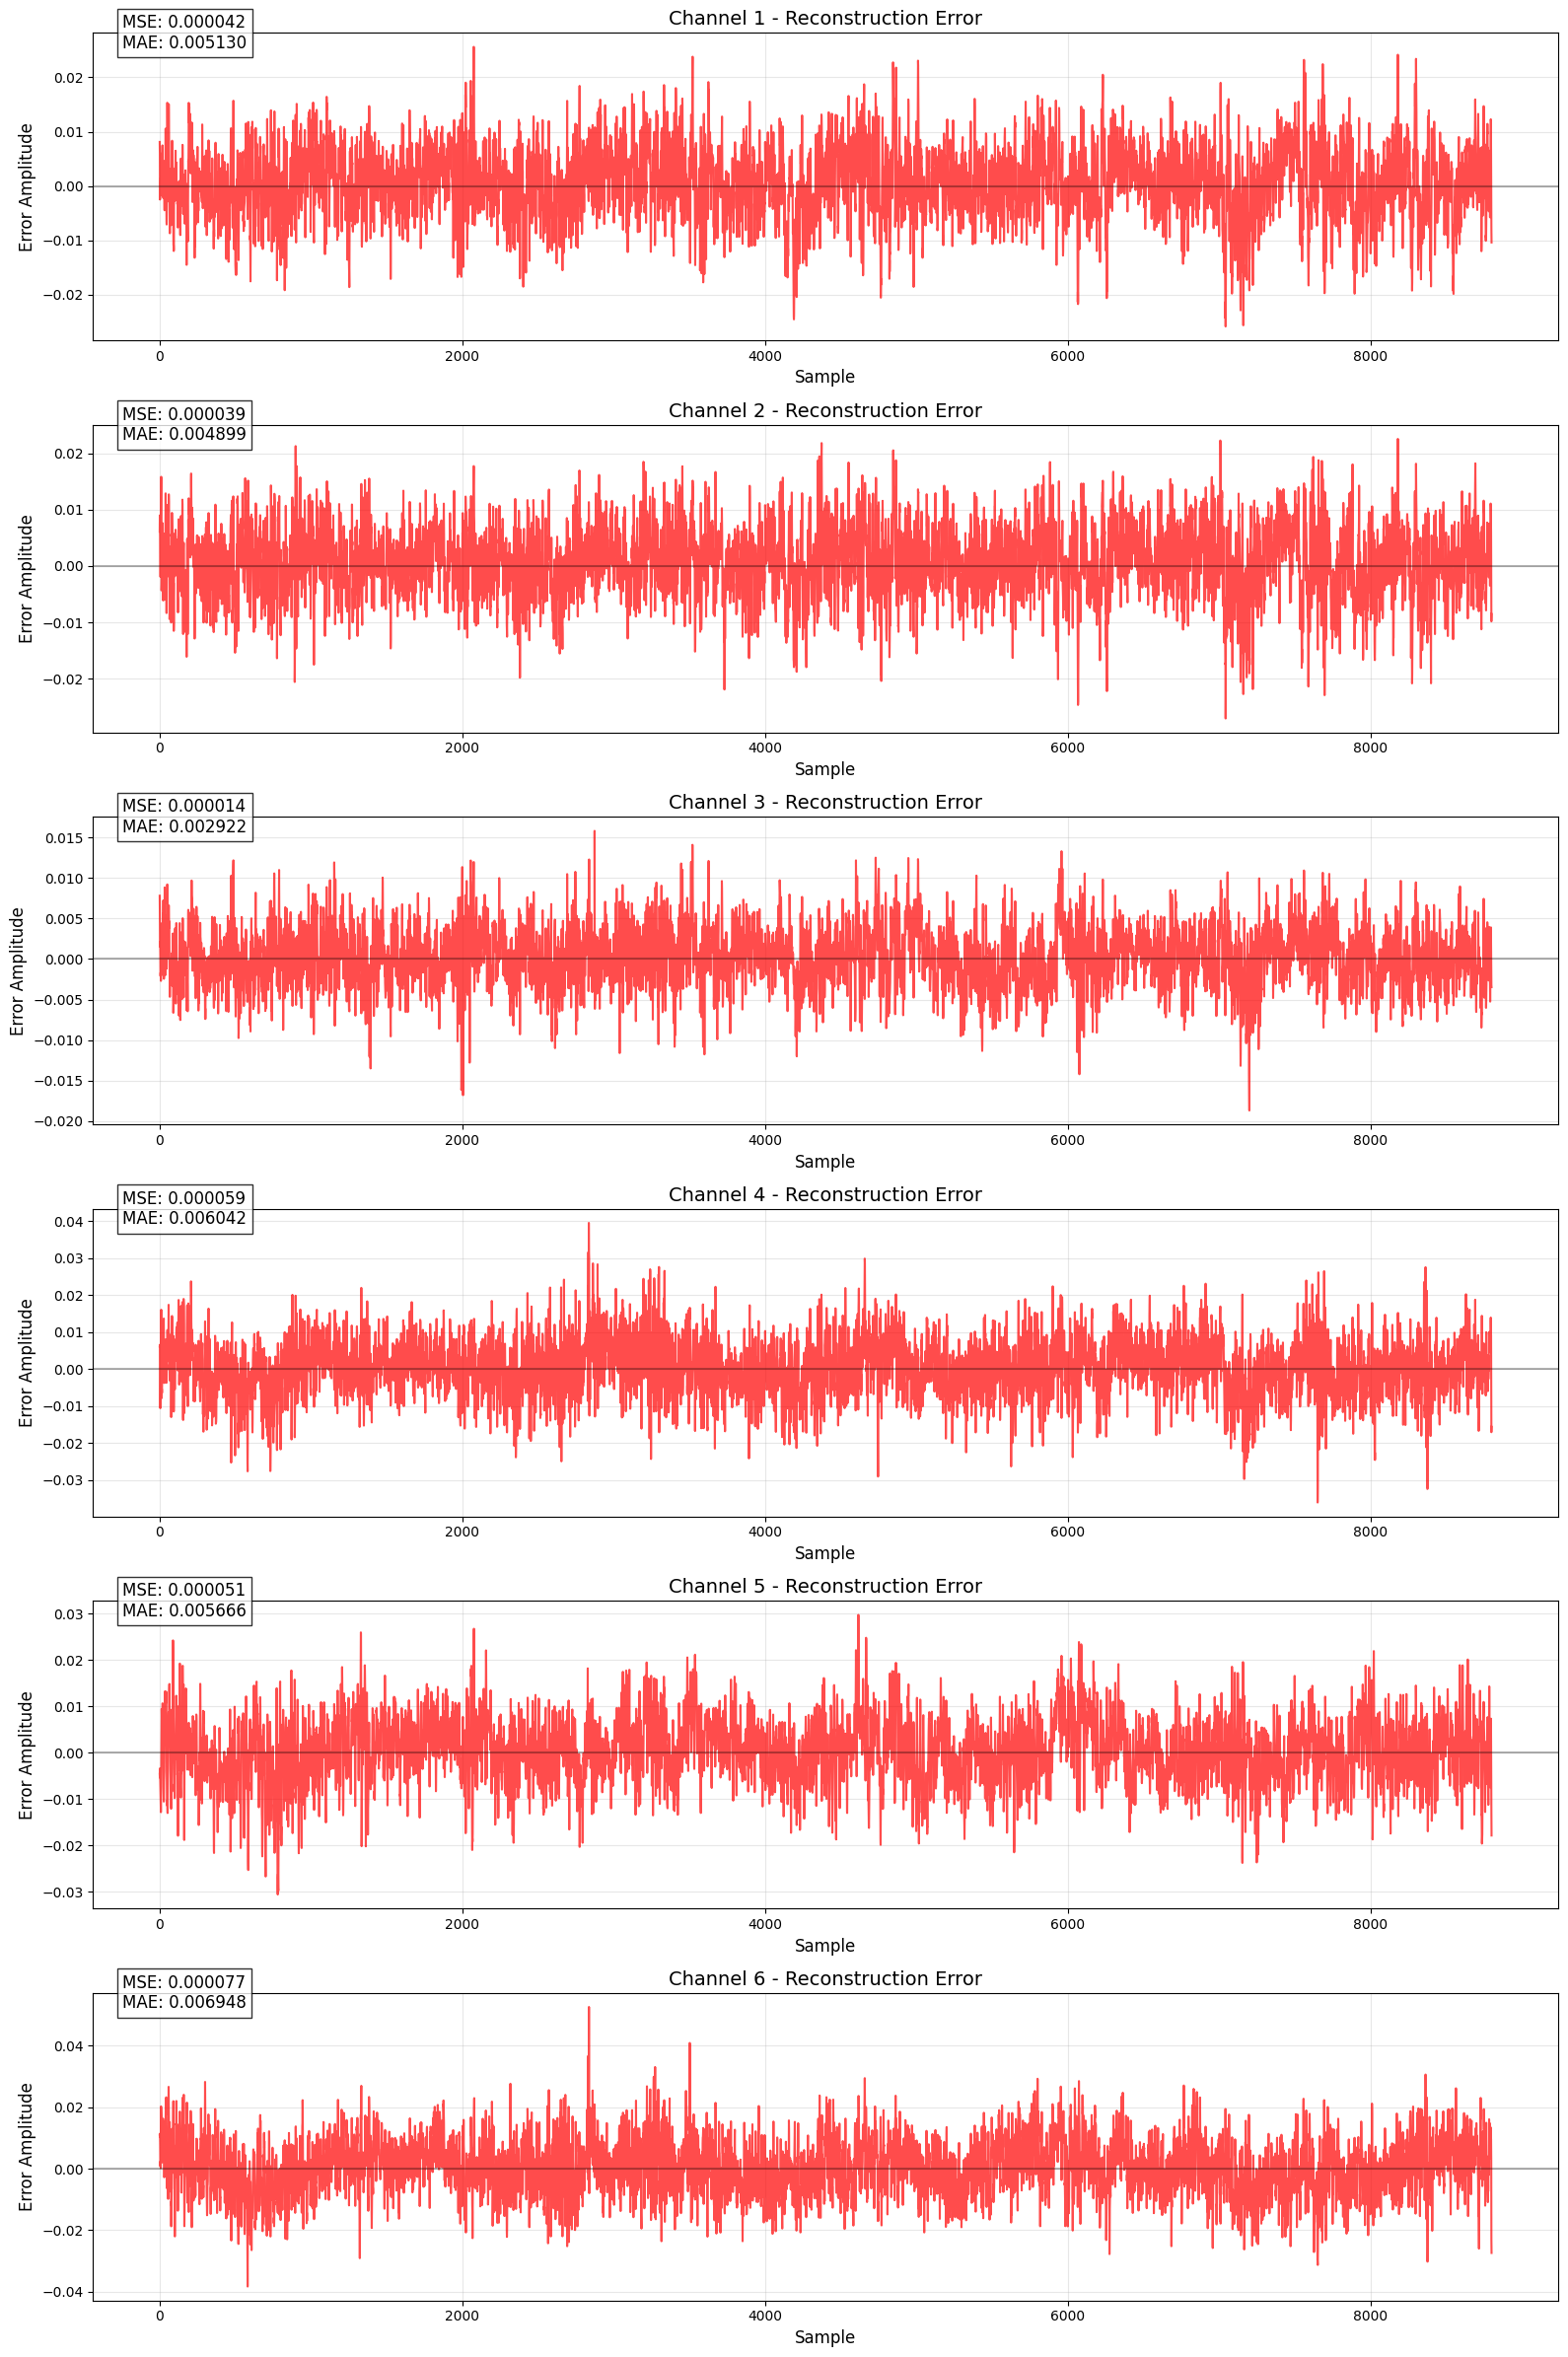

TypeError: _mean() got an unexpected keyword argument 'dim'

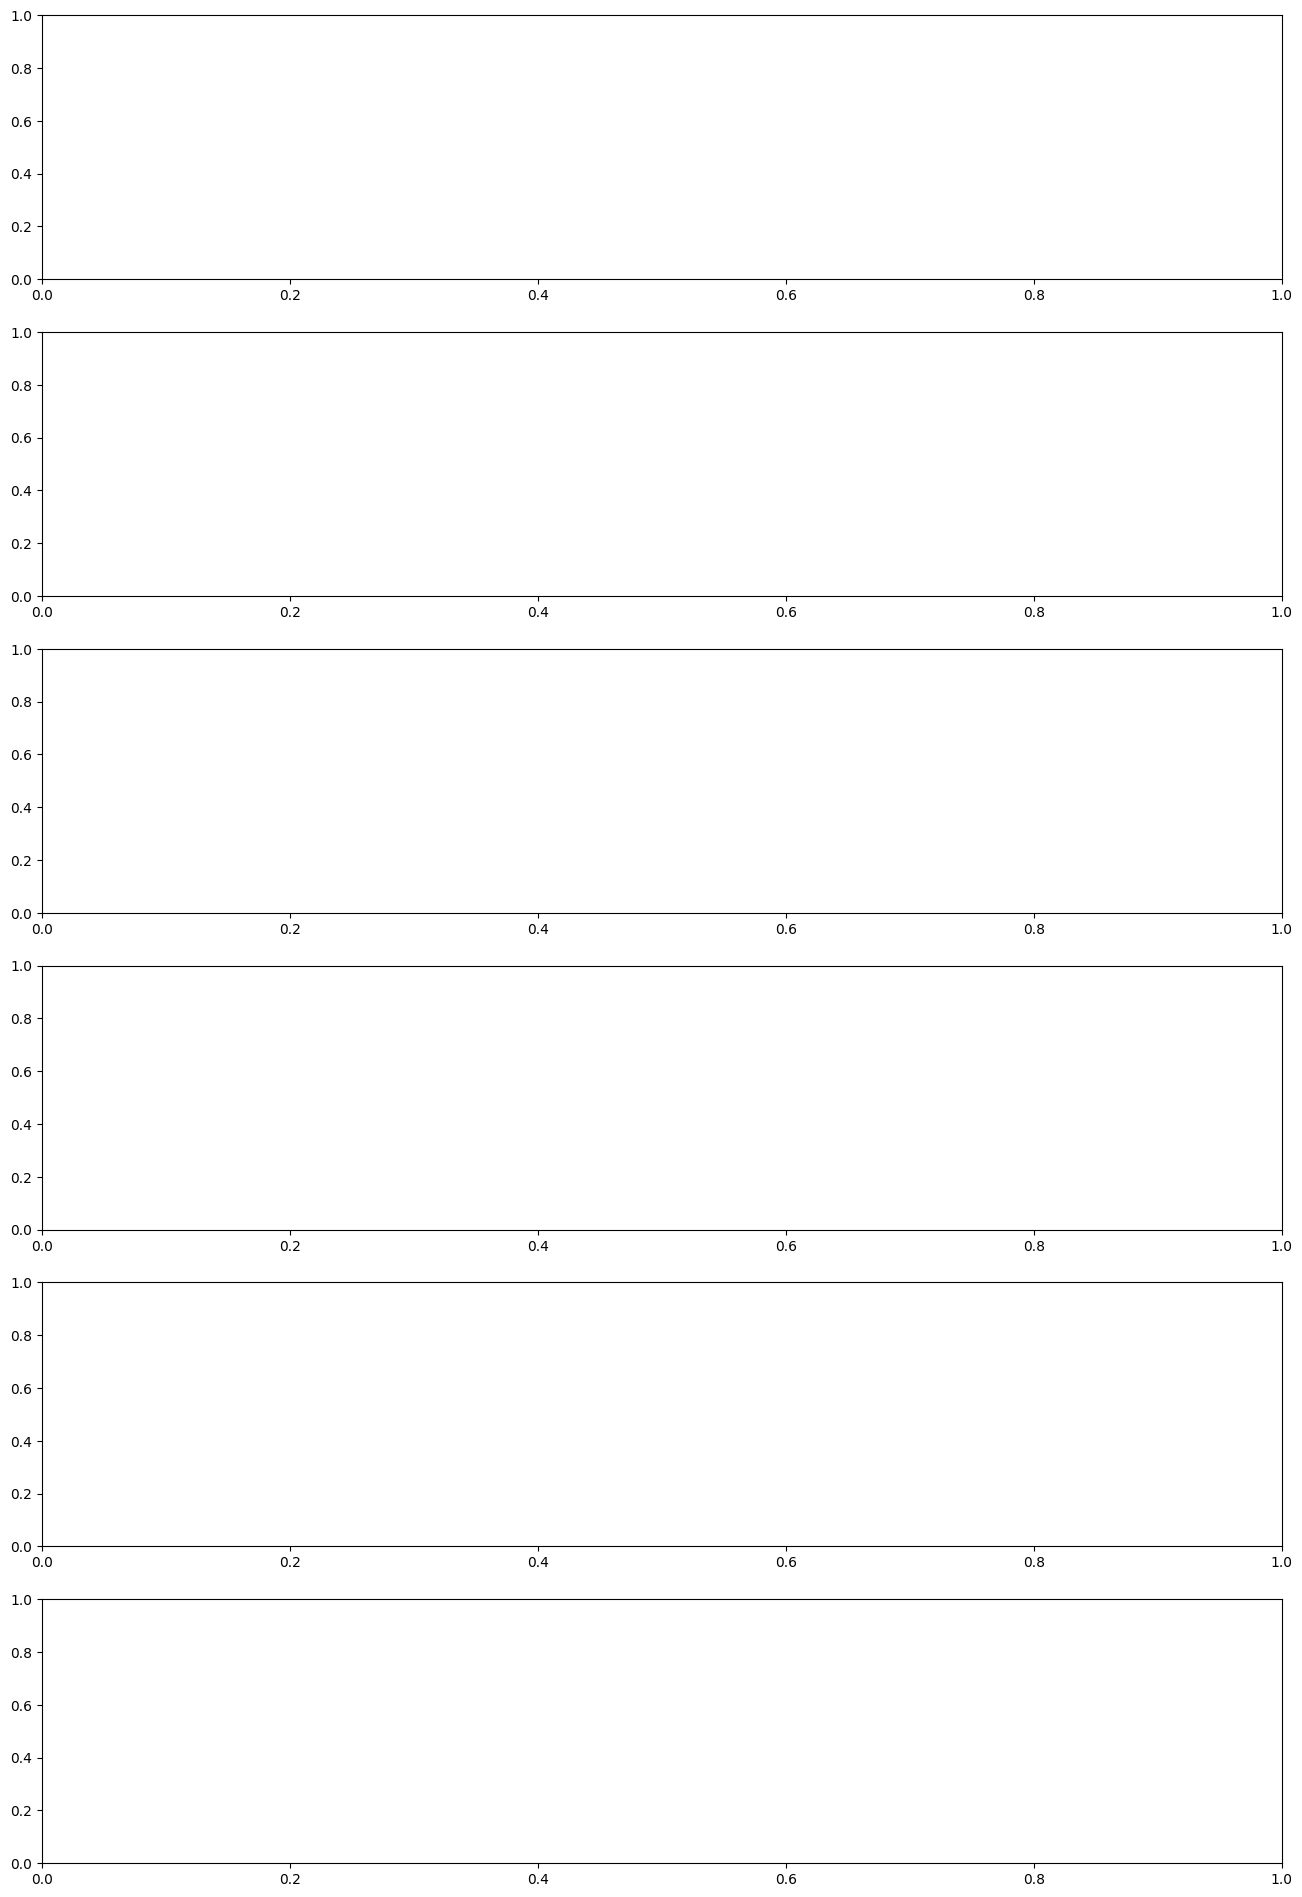

In [4]:
"""
EEG Reconstruction Visualization Script for NeuroLM VQ Model
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pathlib import Path
from dataset import PickleLoader
from model.model_vq import VQ_Align
from model.model_neural_transformer import NTConfig

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
num_channels = 23  # Number of EEG channels

def load_model(ckpt_path, device):
    """Load the VQ model from checkpoint"""
    print(f"Loading model from checkpoint: {ckpt_path}")
    
    # Load checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Get model configuration
    encoder_args = checkpoint['encoder_args']
    decoder_args = checkpoint['decoder_args']
    
    # Create model configuration
    encoder_conf = NTConfig(**encoder_args)
    decoder_conf = NTConfig(**decoder_args)
    
    # Initialize model
    model = VQ_Align(encoder_conf, decoder_conf)
    
    # Fix state dict keys if needed
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    
    # Filter out unwanted keys that might be in the checkpoint but not in the model
    state_dict = {k: v for k, v in state_dict.items() if k not in [
        "domain_classifier.0.weight", "domain_classifier.0.bias", 
        "domain_classifier.2.weight", "domain_classifier.2.bias", 
        "wte.weight", "VQ.quantize.cluster_size", 
        "VQ.quantize.embedding.weight", "VQ.quantize.embedding.cluster_size", 
        "VQ.quantize.embedding.embed_avg", "VQ.quantize.embedding.initted"
    ]}
    
    # Load state dict
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    return model

def visualize_channel_reconstructions_matplotlib(X, X_freq, xrec_raw, xrec_freq, num_channels=23, channels_to_show=None):
    """
    Visualize reconstructions for selected channels using Matplotlib
    
    Args:
        X: Input EEG data [batch, channels, time]
        xrec_raw: Raw domain reconstruction
        xrec_freq: Frequency domain reconstruction
        num_channels: Total number of channels
        channels_to_show: List of channel indices to display (None = all)
    """
    if channels_to_show is None:
        channels_to_show = range(min(6, num_channels))  # Show first 6 channels by default
    
    # Convert to numpy
    X_np = X[0].cpu().numpy()  # First batch
    X_freq_np = X_freq[0].cpu().numpy()  # First batch
    xrec_raw_np = xrec_raw[0].cpu().numpy()
    xrec_freq_np = xrec_freq[0].cpu().numpy()
    
    # Squeeze dimensions if needed
    X_np = X_np.squeeze()
    stop = X_np.shape[0] - X_np.shape[0] % num_channels
    
    # Create a single column of larger plots for each channel
    n_rows = len(channels_to_show)
    fig, axs = plt.subplots(n_rows, 1, figsize=(16, 6
                                                * n_rows))
    
    if n_rows == 1:
        axs = [axs]  # Make iterable for single channel case
    
    for i, ch_idx in enumerate(channels_to_show):
        # Extract channel data
        original_signal = X_np[ch_idx:stop:num_channels, :].flatten()
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()

        # Normalize signals for better comparison
        original_signal = original_signal/((original_signal**2).sum())**0.5
        raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
        # Time domain plot with larger size
        ax = axs[i]
        ax.plot(original_signal, 'b-', label='Original', alpha=0.7, linewidth=1.5)
        ax.plot(raw_recon, 'r-', label='Reconstruction', alpha=0.7, linewidth=1.5)
        ax.set_title(f'Channel {ch_idx+1} - EEG Signal Reconstruction', fontsize=14)
        ax.set_xlabel('Sample', fontsize=12)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add a zoom-in view of a segment for detailed comparison
        segment_length = min(500, len(original_signal))
        segment_start = len(original_signal) // 3  # Start from 1/3 of the signal
        
        # Create an inset axes for the zoomed view
        axins = ax.inset_axes([0.6, 0.6, 0.35, 0.3])
        axins.plot(original_signal[segment_start:segment_start+segment_length], 'b-', linewidth=1.5)
        axins.plot(raw_recon[segment_start:segment_start+segment_length], 'r-', linewidth=1.5)
        axins.set_title('Zoomed Detail', fontsize=10)
        axins.grid(True, alpha=0.3)
        
        # Add connecting lines to show the zoomed region
        ax.indicate_inset_zoom(axins, edgecolor="black")
    
    plt.tight_layout()
    plt.show()
    
    # Create frequency domain reconstruction plots
    fig, axs = plt.subplots(n_rows, 1, figsize=(16, 6 * n_rows))
    
    if n_rows == 1:
        axs = [axs]  # Make iterable for single channel case
    
    for i, ch_idx in enumerate(channels_to_show):
        # Extract channel data for frequency domain
        original_freq = X_freq_np[ch_idx:stop:num_channels, :100].flatten()[:100]
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :100].flatten()[:100]
        
        
        
        # Frequency domain plot
        ax = axs[i]
        ax.plot(original_freq, 'b-', label='Original', alpha=0.7, linewidth=1.5)
        ax.plot(freq_recon, 'g-', label='Freq Reconstruction', alpha=0.7, linewidth=1.5)
        ax.set_title(f'Channel {ch_idx+1} - Frequency Domain Reconstruction', fontsize=14)
        ax.set_xlabel('Frequency Bin', fontsize=12)
        ax.set_ylabel('Magnitude', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add a zoom-in view of a segment for detailed comparison
        segment_length = min(500, len(original_freq))
        segment_start = len(original_freq) // 3  # Start from 1/3 of the signal
        
        # Create an inset axes for the zoomed view
        axins = ax.inset_axes([0.6, 0.6, 0.35, 0.3])
        axins.plot(original_freq[segment_start:segment_start+segment_length], 'b-', linewidth=1.5)
        axins.plot(freq_recon[segment_start:segment_start+segment_length], 'g-', linewidth=1.5)
        axins.set_title('Zoomed Detail', fontsize=10)
        axins.grid(True, alpha=0.3)
        
        # Add connecting lines to show the zoomed region
        ax.indicate_inset_zoom(axins, edgecolor="black")
    
    plt.tight_layout()
    plt.show()
    
    # Create error visualization
    fig, axs = plt.subplots(n_rows, 1, figsize=(16, 4 * n_rows))
    
    if n_rows == 1:
        axs = [axs]  # Make iterable for single channel case
    
    for i, ch_idx in enumerate(channels_to_show):
        # Extract channel data
        original_signal = X_np[ch_idx:stop:num_channels, :].flatten()#[:600] 
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()#[:600]
        
        # Normalize signals
        original_signal = original_signal/((original_signal**2).sum())**0.5
        raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
        # Compute error
        raw_error = original_signal - raw_recon
        
        # Error plot
        ax = axs[i]
        ax.plot(raw_error, 'r-', alpha=0.7, linewidth=1.5)
        ax.set_title(f'Channel {ch_idx+1} - Reconstruction Error', fontsize=14)
        ax.set_xlabel('Sample', fontsize=12)
        ax.set_ylabel('Error Amplitude', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add horizontal lines at zero
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        
        # Add error statistics as text
        mse = np.mean(raw_error**2)
        mae = np.mean(np.abs(raw_error))
        ax.text(0.02, 0.95, f'MSE: {mse:.6f}\nMAE: {mae:.6f}', 
                transform=ax.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Create error visualization for frequency domain
    fig, axs = plt.subplots(n_rows, 1, figsize=(16, 4 * n_rows))
    
    if n_rows == 1:
        axs = [axs]  # Make iterable for single channel case
    
    for i, ch_idx in enumerate(channels_to_show):
        # Extract channel data for frequency domain
        original_freq = X_freq_np[ch_idx:stop:num_channels, :100].flatten()#[:100]
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :100].flatten()#[:100]
        
        
        
        # Compute error
        freq_error = (original_freq - freq_recon).reshape(-1, 100).mean(dim=-1)
        
        # Error plot
        ax = axs[i]
        ax.plot(freq_error, 'g-', alpha=0.7, linewidth=1.5)
        ax.set_title(f'Channel {ch_idx+1} - Frequency Domain Error', fontsize=14)
        ax.set_xlabel('Frequency Bin', fontsize=12)
        ax.set_ylabel('Error Magnitude', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add horizontal lines at zero
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        
        # Add error statistics as text
        mse = np.mean(freq_error**2)
        mae = np.mean(np.abs(freq_error))
        ax.text(0.02, 0.95, f'MSE: {mse:.6f}\nMAE: {mae:.6f}', 
                transform=ax.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    # Create heatmap showing reconstruction quality across all channels
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Prepare data for heatmap
    all_channels_raw_error = []
    
    for ch_idx in range(num_channels):
        # Extract channel data
        original_signal = X_np[ch_idx:stop:num_channels, :].flatten()
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()
        
        # Normalize signals
        original_signal = original_signal/((original_signal**2).sum())**0.5
        raw_recon = raw_recon/((raw_recon**2).sum())**0.5
        
        # Compute mean squared error
        raw_mse = np.mean((original_signal - raw_recon)**2)
        all_channels_raw_error.append(raw_mse)
    
    # Create heatmap
    im = ax.imshow(np.array(all_channels_raw_error).reshape(-1, 1), aspect='auto', cmap='viridis_r')
    ax.set_title('Reconstruction MSE by Channel', fontsize=16)
    ax.set_xlabel('MSE', fontsize=14)
    ax.set_ylabel('Channel', fontsize=14)
    ax.set_yticks(range(num_channels))
    ax.set_yticklabels([f'Ch {i+1}' for i in range(num_channels)])
    plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Main execution functions
def process_batch(model, batch, device, return_reconstruction=True):
    """Process a batch of EEG data through the model"""
    X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
    X = X.float().to(device, non_blocking=True)
    Y_freq = Y_freq.float().to(device, non_blocking=True)
    Y_raw = Y_raw.float().to(device, non_blocking=True)
    input_chans = input_chans.to(device, non_blocking=True)
    input_time = input_time.to(device, non_blocking=True)
    input_mask = input_mask.to(device, non_blocking=True)
    
    with torch.no_grad():
        if return_reconstruction:
            (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                return_reconstruction=True
            )
        else:
            loss, encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask
            )
            xrec_freq, xrec_raw = None, None
    
    return X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log

def analyze_eeg_reconstructions(model, data_loader, device, num_channels=23, num_batches=5, cache = None):
    """
    Perform comprehensive analysis of EEG reconstructions
    
    Args:
        model: The trained VQ_Align model
        data_loader: DataLoader with EEG samples
        device: Device to run inference on
        num_channels: Number of EEG channels
        num_batches: Number of batches to analyze
    """
    model.eval()  # Set model to evaluation mode
    
    all_metrics = []
    
    for batch_idx, batch in enumerate(data_loader):
        if batch_idx >= num_batches:
            break
        if cache is None:
            print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
            
            # Process batch
            X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
                model, batch, device
            )
        else:
            X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = cache
            
        print(f"Input shape: {X.shape}")
        print(f"Raw reconstruction shape: {xrec_raw.shape}")
        print(f"Freq reconstruction shape: {xrec_freq.shape}")
        
        # Visualize channel reconstructions with Matplotlib
        print("\nGenerating Matplotlib visualizations...")
        # freq, raw = model.VQ.decode(quantize,input_chans, input_time)
        visualize_channel_reconstructions_matplotlib(X,Y_freq, xrec_raw, xrec_freq, num_channels=num_channels)
 
        # 4. Evaluate reconstruction quality
        print("\nEvaluating reconstruction quality...")
        # metrics = evaluate_reconstruction_quality(X, xrec_raw, xrec_freq, num_channels=num_channels)
        metrics['batch_idx'] = batch_idx
        all_metrics.append(metrics)
        
        print(f"Completed analysis for batch {batch_idx+1}")
    
    # Combine metrics from all batches
    if all_metrics:
        combined_metrics = pd.concat(all_metrics)
        
        # Aggregate results across batches
        print("\n=== Overall Reconstruction Quality (All Batches) ===")
        print(f"Average Raw Correlation: {combined_metrics['Raw_Correlation'].mean():.4f}")
        print(f"Average Freq Correlation: {combined_metrics['Freq_Correlation'].mean():.4f}")
        print(f"Average Raw MSE: {combined_metrics['Raw_MSE'].mean():.4e}")
        print(f"Average Freq MSE: {combined_metrics['Freq_MSE'].mean():.4e}")
        
        return combined_metrics
    
    return None

# Main execution

from dataset import PickleLoader
# data_dir = '/workspace/tuh_full'
# files = Path(data_dir).rglob('*.pkl')
# files = [file for file in files][:10]
# dataset1 = PickleLoader(files)

# data_loader1 = torch.utils.data.DataLoader(
#     dataset1,
#     batch_size=1,
#     num_workers=10,
#     pin_memory=True,
#     drop_last=True,
#     shuffle=True
# )


# data_dir = '/workspace/NeuroLM-Decode/pkl_data_2/'
# files = Path(data_dir).rglob('*.pkl')
# files = [file for file in files][:10]
# dataset2 = PickleLoader(files)

# data_loader2 = torch.utils.data.DataLoader(
#     dataset2,
#     batch_size=1,
#     num_workers=10,
#     pin_memory=True,
#     drop_last=True,
#     shuffle=True
# )


if __name__ == "__main__":
    # Configuration
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_channels = 23
    batch_size = 1
    batch = next(iter(data_loader1))
    X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
        model, batch, device
    )
    # # Run analysis
    metrics = analyze_eeg_reconstructions(model, data_loader1, device, num_channels=num_channels, num_batches=1, cache = (X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log))
    
    print("Analysis complete!")

In [ ]:

# Main execution functions
def process_batch(model, batch, device, return_reconstruction=True):
    """Process a batch of EEG data through the model"""
    X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
    X = X.float().to(device, non_blocking=True)
    Y_freq = Y_freq.float().to(device, non_blocking=True)
    Y_raw = Y_raw.float().to(device, non_blocking=True)
    input_chans = input_chans.to(device, non_blocking=True)
    input_time = input_time.to(device, non_blocking=True)
    input_mask = input_mask.to(device, non_blocking=True)
    
    with torch.no_grad():
        if return_reconstruction:
            (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                return_reconstruction=True
            )
        else:
            loss, encoder_features, log = model.VQ(
                X, Y_freq, Y_raw, input_chans, input_time, input_mask
            )
            xrec_freq, xrec_raw = None, None
    
    return X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log

def analyze_eeg_reconstructions(model, data_loader, device, num_channels=23, num_batches=5):
    """
    Perform comprehensive analysis of EEG reconstructions
    
    Args:
        model: The trained VQ_Align model
        data_loader: DataLoader with EEG samples
        device: Device to run inference on
        num_channels: Number of EEG channels
        num_batches: Number of batches to analyze
    """
    model.eval()  # Set model to evaluation mode
    
    all_metrics = []
    
    for batch_idx, batch in enumerate(data_loader):
        if batch_idx >= num_batches:
            break
        
        print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
        
        # Process batch
        X, Y_freq, Y_raw, input_chans, input_time, input_mask, xrec_freq, xrec_raw, encoder_features, log = process_batch(
            model, batch, device
        )
        
        print(f"Input shape: {X.shape}")
        print(f"Raw reconstruction shape: {xrec_raw.shape}")
        print(f"Freq reconstruction shape: {xrec_freq.shape}")
        
        # 1. Visualize channel reconstructions with Matplotlib
        print("\nGenerating Matplotlib visualizations...")
        visualize_channel_reconstructions_matplotlib(X, Y_freq, xrec_raw, xrec_freq, num_channels=num_channels)
 
        # 4. Evaluate reconstruction quality
        print("\nEvaluating reconstruction quality...")
        metrics = evaluate_reconstruction_quality(X, xrec_raw, xrec_freq, num_channels=num_channels)
        metrics['batch_idx'] = batch_idx
        all_metrics.append(metrics)
        
        print(f"Completed analysis for batch {batch_idx+1}")
    
    # Combine metrics from all batches
    if all_metrics:
        combined_metrics = pd.concat(all_metrics)
        
        # Aggregate results across batches
        print("\n=== Overall Reconstruction Quality (All Batches) ===")
        print(f"Average Raw Correlation: {combined_metrics['Raw_Correlation'].mean():.4f}")
        print(f"Average Freq Correlation: {combined_metrics['Freq_Correlation'].mean():.4f}")
        print(f"Average Raw MSE: {combined_metrics['Raw_MSE'].mean():.4e}")
        print(f"Average Freq MSE: {combined_metrics['Freq_MSE'].mean():.4e}")
        
        return combined_metrics
    
    return None

# Main execution


if __name__ == "__main__":
    # Configuration
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_channels = 23
    batch_size = 1
    
    # Run analysis
    metrics = analyze_eeg_reconstructions(model, data_loader2, device, num_channels=num_channels, num_batches=3)
    
    print("Analysis complete!")

# Reconstr


In [20]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch


def enhance_neurolm_reconstruction(xrec_raw, xrec_freq, method='blending', 
                                window_length=200, hop_length=None, window_func=None, 
                                freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information from PyTorch tensors.
    
    Parameters:
    - xrec_raw: Time-domain reconstruction tensor [batch, channels, time] or [channels, time]
    - xrec_freq: Frequency domain reconstruction tensor [batch, channels, freq] or [channels, freq]
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction tensor with same shape as xrec_raw
    """
    # Determine if we have batch dimension
    has_batch = len(xrec_raw.shape) == 3
    
    # Convert to numpy for processing
    device = xrec_raw.device
    if has_batch:
        batch_size = xrec_raw.shape[0]
        n_channels = xrec_raw.shape[1]
        time_length = xrec_raw.shape[2]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
    else:
        n_channels = xrec_raw.shape[0]
        time_length = xrec_raw.shape[1]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
        batch_size = 1
        # Add batch dimension for consistent processing
        xrec_raw_np = xrec_raw_np.reshape(1, n_channels, time_length)
        xrec_freq_np = xrec_freq_np.reshape(1, n_channels, xrec_freq_np.shape[-1])
    
    # Process each batch and channel separately
    enhanced_recon_np = np.zeros_like(xrec_raw_np)
    
    for b in range(batch_size):
        for c in range(n_channels):
            # Get time domain signal for this channel
            time_signal = xrec_raw_np[b, c]
            
            # Convert power spectra windows to appropriate format
            # We need to reshape the power spectra for this channel
            # The power spectra should be [n_windows, n_freqs]
            freq_length = xrec_freq_np.shape[-1]
            n_windows = time_length // hop_length if hop_length else time_length // (window_length // 2)
            
            # Handle the case where power spectra might be arranged differently
            # This depends on how your model outputs the frequency data
            if freq_length == 100:  # As mentioned in prompt, 100 points for power spectrum
                # If the power spectrum is already in window format
                power_spectra = xrec_freq_np[b, c].reshape(n_windows, freq_length)
            else:
                # If power spectra need to be extracted from continuous data
                power_spectra = []
                effective_hop = hop_length if hop_length else window_length // 2
                
                for i in range(0, time_length - window_length + 1, effective_hop):
                    window_data = time_signal[i:i+window_length]
                    # Calculate power spectrum for this window
                    window_fft = np.fft.rfft(window_data)
                    window_power = np.abs(window_fft)**2
                    power_spectra.append(window_power)
                
                power_spectra = np.array(power_spectra)
            
            # Use the core function to enhance this channel
            enhanced_channel = enhance_eeg_reconstruction(
                time_signal, power_spectra, method, 
                window_length, hop_length, window_func,
                freq_transition, freq_slope, highpass_cutoff
            )
            
            # Store the enhanced result
            enhanced_recon_np[b, c] = enhanced_channel[:time_length]
    
    # Convert back to tensor and match original shape
    if has_batch:
        enhanced_recon = torch.tensor(enhanced_recon_np, device=device)
    else:
        enhanced_recon = torch.tensor(enhanced_recon_np[0], device=device)
    
    return enhanced_recon


def enhance_eeg_reconstruction(time_recon, power_spectra, method='blending', 
                              window_length=200, hop_length=None, window_func=None, 
                              freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information.
    
    Parameters:
    - time_recon: numpy array of time-domain reconstruction (shape: [n_samples])
    - power_spectra: numpy array of power spectra (shape: [n_windows, n_freqs])
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    n_freqs = power_spectra.shape[1]
    expected_rfft_length = window_length // 2 + 1  # For real FFT
    
    # Select the appropriate enhancement method
    if method == 'phase_recovery':
        return phase_recovery_enhancement(time_recon, power_spectra, window_length, 
                                         hop_length, window_func)
    elif method == 'blending':
        return freq_blending_enhancement(time_recon, power_spectra, window_length, 
                                        hop_length, window_func, freq_transition, freq_slope)
    elif method == 'highpass':
        return highpass_enhancement(time_recon, power_spectra, window_length, 
                                   hop_length, window_func, highpass_cutoff)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'phase_recovery', 'blending', or 'highpass'")


def phase_recovery_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, window_func=None):
    """
    Enhance reconstruction using phase from time domain and magnitude from power spectra.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract phase from time-domain FFT
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Combine magnitude from power spectrum with phase from time domain
        enhanced_fft = magnitude_power * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon


def freq_blending_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                             window_func=None, freq_transition=0.3, freq_slope=5.0):
    """
    Enhance reconstruction with frequency-dependent blending of original and power spectrum.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    expected_rfft_length = window_length // 2 + 1
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # Create frequency-dependent weights for blending
    freq_indices = np.arange(expected_rfft_length)
    normalized_freqs = freq_indices / (expected_rfft_length - 1)
    
    # Sigmoid weighting: low values for low frequencies, high values for high frequencies
    power_weights = 1.0 / (1.0 + np.exp(-freq_slope * (normalized_freqs - freq_transition)))
    time_weights = 1.0 - power_weights
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract magnitude and phase from time-domain FFT
        magnitude_time = np.abs(fft_time)
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Frequency-dependent blending of magnitudes
        blended_magnitude = (time_weights * magnitude_time) + (power_weights * magnitude_power)
        
        # Combine blended magnitude with original phase
        enhanced_fft = blended_magnitude * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon


def highpass_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                        window_func=None, cutoff_freq=0.3):
    """
    Enhance reconstruction by adding high-frequency components from power spectra.
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # First, reconstruct signal from power spectra using phase from time domain
    power_recon = phase_recovery_enhancement(time_recon, power_spectra, window_length, hop_length, window_func)
    
    # Design high-pass filter
    nyquist = 0.5  # Normalized Nyquist frequency
    cutoff = cutoff_freq * nyquist
    b, a = signal.butter(5, cutoff, btype='high', analog=False)
    
    # Apply high-pass filter to power-based reconstruction
    highpass_power_recon = signal.filtfilt(b, a, power_recon)
    
    # Combine original time reconstruction with high-pass filtered power reconstruction
    enhanced_recon = time_recon + highpass_power_recon
    
    return enhanced_recon


def adjust_power_spectrum(power_spectrum, phase, fft_time):
    """
    Adjust power spectrum to match expected dimensions for rfft output.
    """
    expected_length = len(phase)
    
    if len(power_spectrum) != expected_length:
        adjusted_power = np.zeros(expected_length)
        
        if len(power_spectrum) == expected_length - 1:
            # Missing DC component
            adjusted_power[1:] = power_spectrum
            adjusted_power[0] = np.abs(fft_time[0])**2  # Use DC from time domain
        else:
            # Missing highest frequency bin or different size
            min_len = min(len(power_spectrum), expected_length)
            adjusted_power[:min_len] = power_spectrum[:min_len]
            
            # Fill remaining with time-domain data if needed
            if expected_length > min_len:
                adjusted_power[min_len:] = np.abs(fft_time[min_len:])**2
    else:
        adjusted_power = power_spectrum
    
    # Convert power to magnitude
    return np.sqrt(adjusted_power)


def visualize_enhancement(original_signal=None, time_recon=None, enhanced_recon=None, freq_recon=None,
                         sampling_rate=None, window_length=200):
    """
    Visualize the original, reconstructed, and enhanced signals in time and frequency domains.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Determine signal lengths and time axis
    signals = [s for s in [original_signal, time_recon, enhanced_recon] if s is not None]
    min_length = min(len(s) for s in signals)
    
    time_axis = np.arange(min_length)
    if sampling_rate:
        time_axis = time_axis / sampling_rate
        time_label = 'Time (s)'
    else:
        time_label = 'Sample'
    
    # Time domain plot
    ax = axes[0, 0]
    if original_signal is not None:
        ax.plot(time_axis, original_signal[:min_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(time_axis, time_recon[:min_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(time_axis, enhanced_recon[:min_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain Comparison')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Zoomed time domain (show detail of high frequency differences)
    ax = axes[0, 1]
    zoom_start = min(1000, min_length // 2)
    zoom_length = min(500, min_length // 4)
    zoom_time = time_axis[zoom_start:zoom_start+zoom_length]
    
    if original_signal is not None:
        ax.plot(zoom_time, original_signal[zoom_start:zoom_start+zoom_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(zoom_time, time_recon[zoom_start:zoom_start+zoom_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(zoom_time, enhanced_recon[zoom_start:zoom_start+zoom_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain (Zoomed)')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Frequency domain plot
    ax = axes[1, 0]
    n_fft = window_length * 2
    
    # Calculate FFT for all signals
    def calculate_fft(signal):
        fft_result = np.abs(np.fft.rfft(signal[:min_length], n=n_fft))
        # Normalize for better comparison
        return fft_result / np.max(fft_result) if np.max(fft_result) > 0 else fft_result
    
    freq_axis = np.fft.rfftfreq(n_fft, d=1.0/sampling_rate if sampling_rate else 1.0)
    
    if original_signal is not None:
        original_fft = calculate_fft(original_signal)
        ax.plot(freq_axis, original_fft, 'b-', label='Original')
    
    if time_recon is not None:
        time_recon_fft = calculate_fft(time_recon)
        ax.plot(freq_axis, time_recon_fft, 'r-', label='Time Reconstruction')
    
    if freq_recon is not None:
        enhanced_fft = freq_recon
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Recon')
    if enhanced_recon is not None:
        enhanced_fft = calculate_fft(enhanced_recon)
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Enhanced')
    
    ax.set_title('Frequency Domain Comparison')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    # High frequency zoom
    ax = axes[1, 1]
    # Focus on higher frequencies (second half of the spectrum)
    high_freq_start = len(freq_axis) // 4
    
    if original_signal is not None:
        ax.plot(freq_axis[high_freq_start:], original_fft[high_freq_start:], 'b-', label='Original')
    
    if time_recon is not None:
        ax.plot(freq_axis[high_freq_start:], time_recon_fft[high_freq_start:], 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        ax.plot(freq_axis[high_freq_start:], enhanced_fft[high_freq_start:], 'g-', label='Enhanced')
    
    ax.set_title('High Frequency Detail')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    plt.tight_layout()
    return fig

/Users/adamsobieszek/PycharmProjects/NeuroLM-Decode/model/model_vq.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Testing enhancement method: phase_recovery


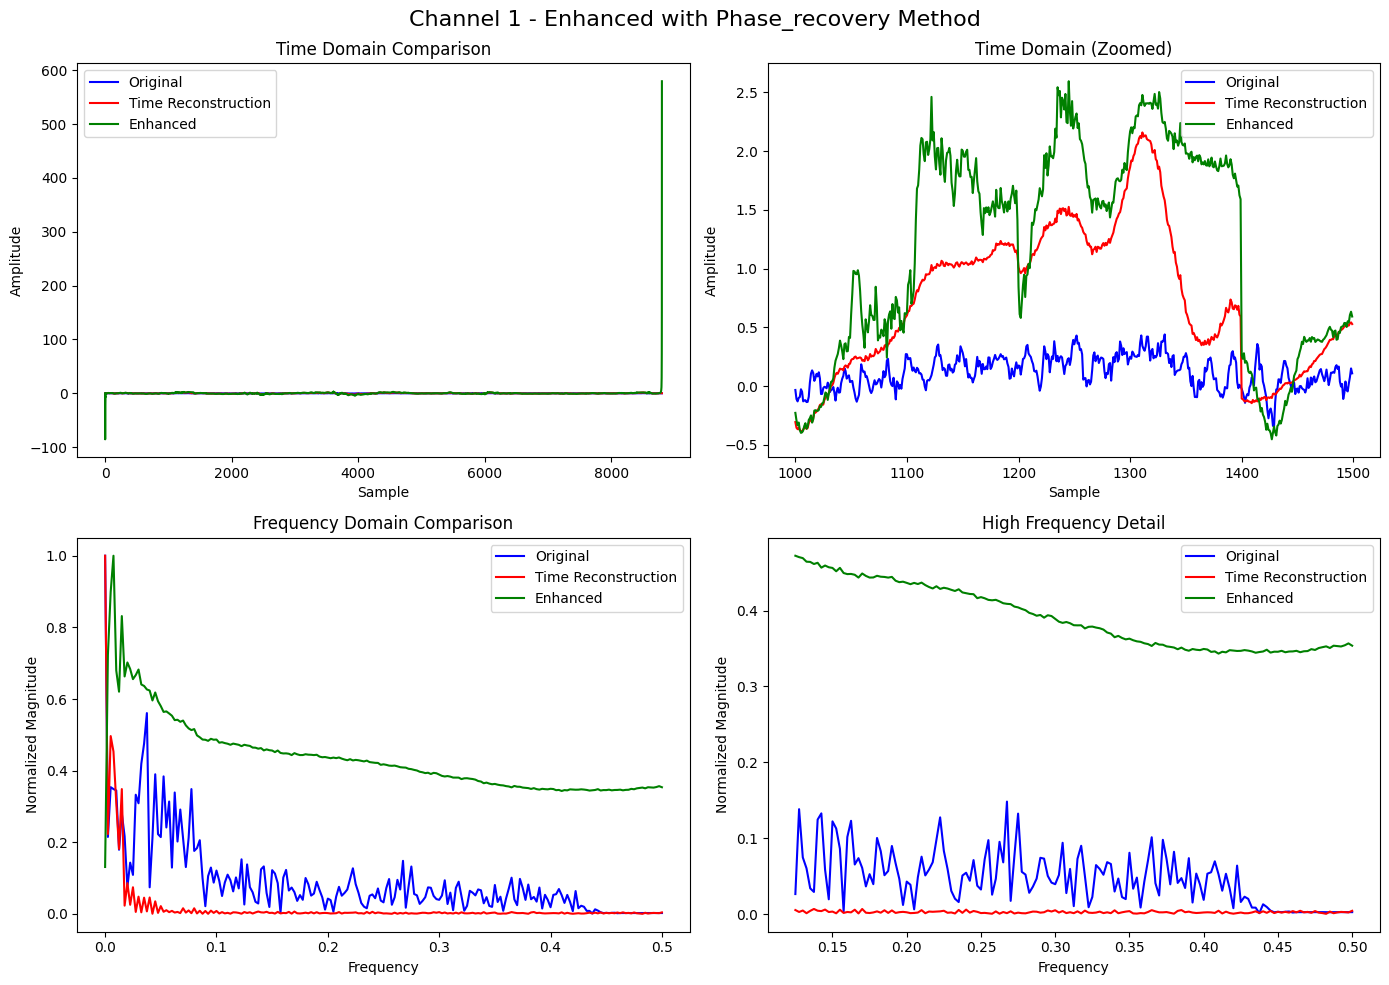


Channel 1 Metrics:
MSE - Raw: 0.000057, Enhanced: 0.000200, Improvement: -250.87%
Correlation - Raw: 0.749179, Enhanced: 0.118019, Improvement: -84.25%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000005, Improvement: -46.67%


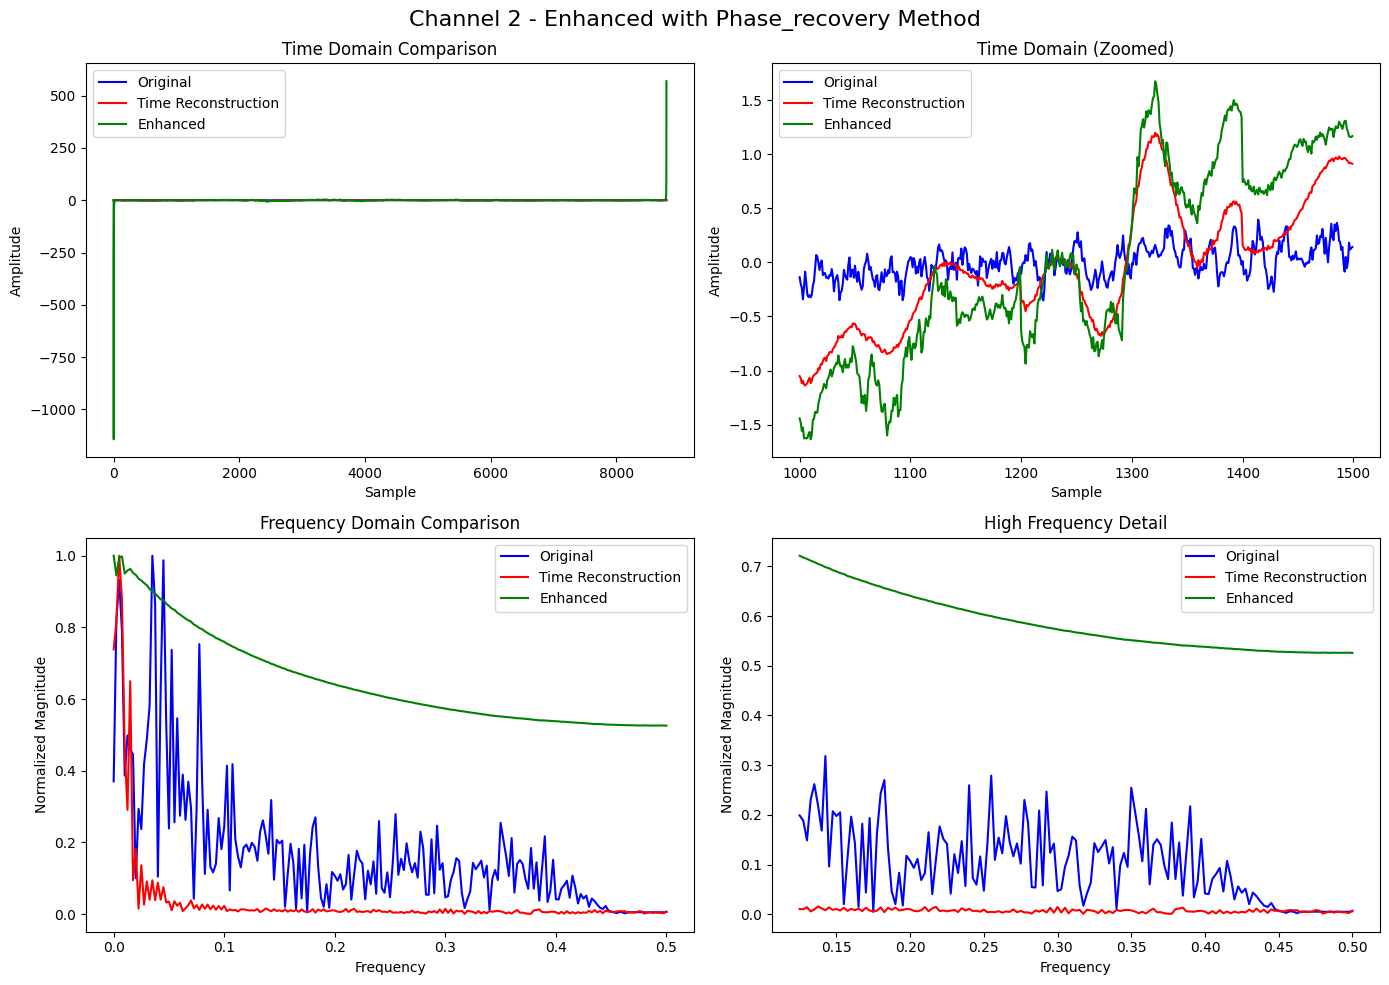


Channel 2 Metrics:
MSE - Raw: 0.000050, Enhanced: 0.000211, Improvement: -324.06%
Correlation - Raw: 0.781668, Enhanced: 0.072154, Improvement: -90.77%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000006, Improvement: -157.77%


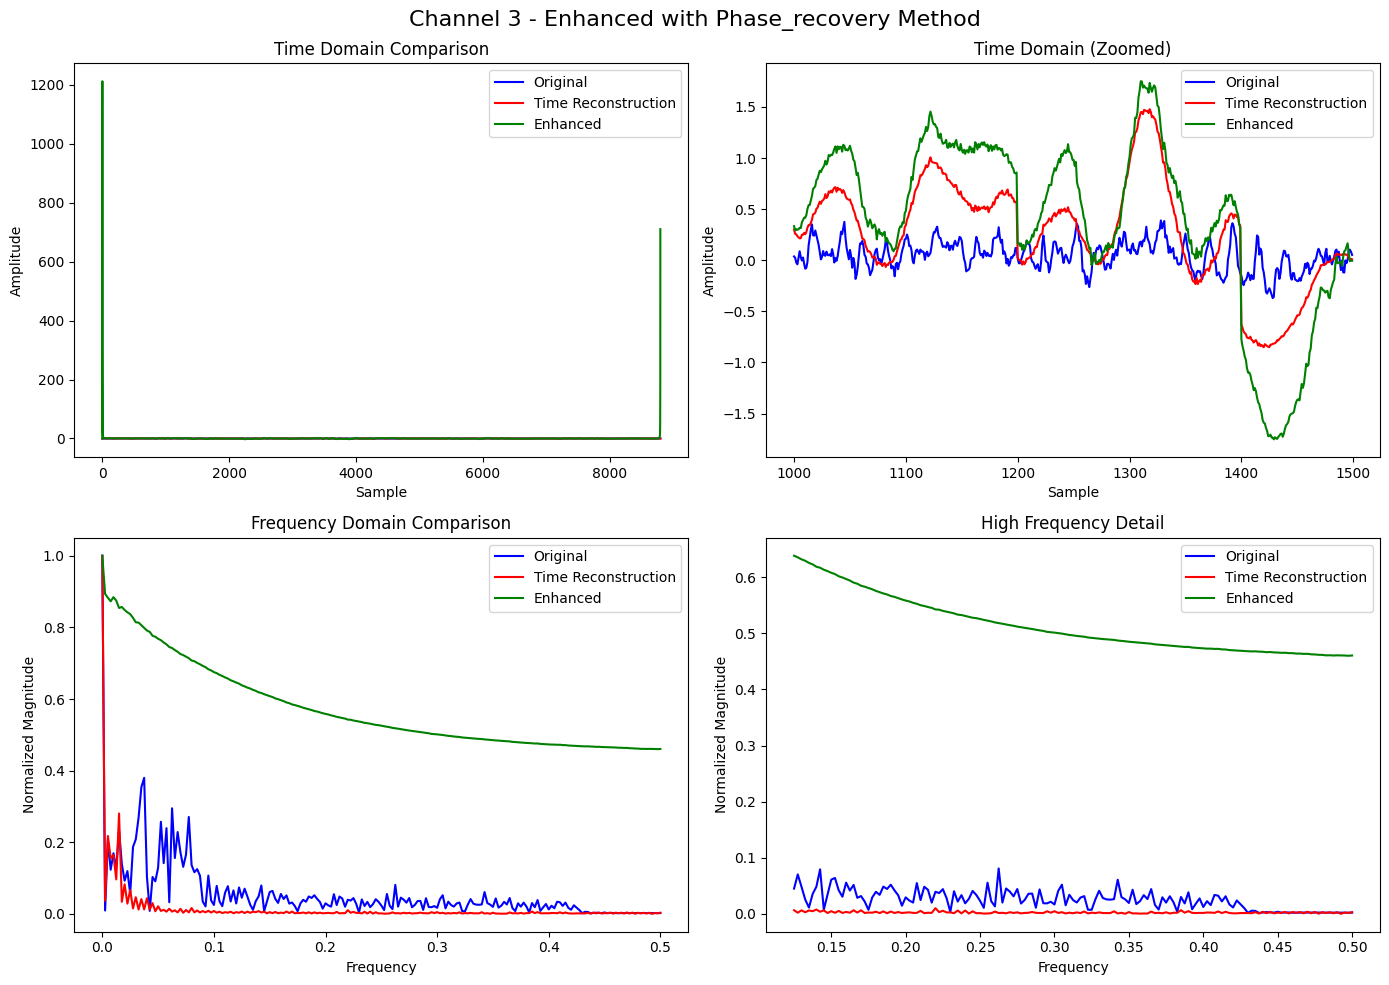


Channel 3 Metrics:
MSE - Raw: 0.000112, Enhanced: 0.000222, Improvement: -98.19%
Correlation - Raw: 0.507035, Enhanced: 0.021616, Improvement: -95.74%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000001, Improvement: 83.71%

Testing enhancement method: blending


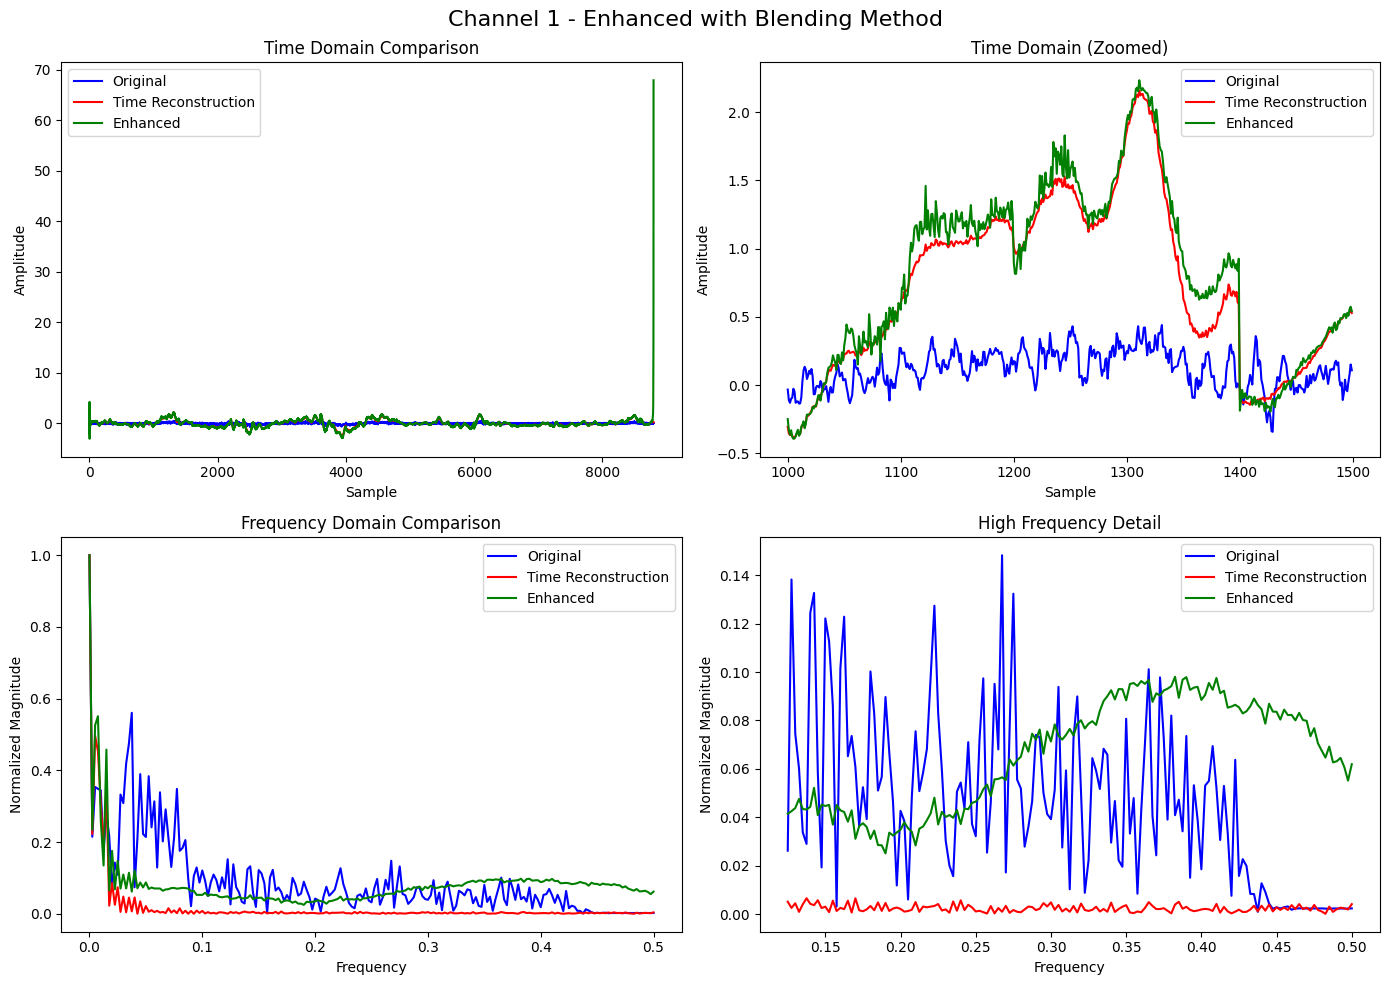


Channel 1 Metrics:
MSE - Raw: 0.000057, Enhanced: 0.000113, Improvement: -97.52%
Correlation - Raw: 0.749179, Enhanced: 0.503591, Improvement: -32.78%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000000, Improvement: 89.13%


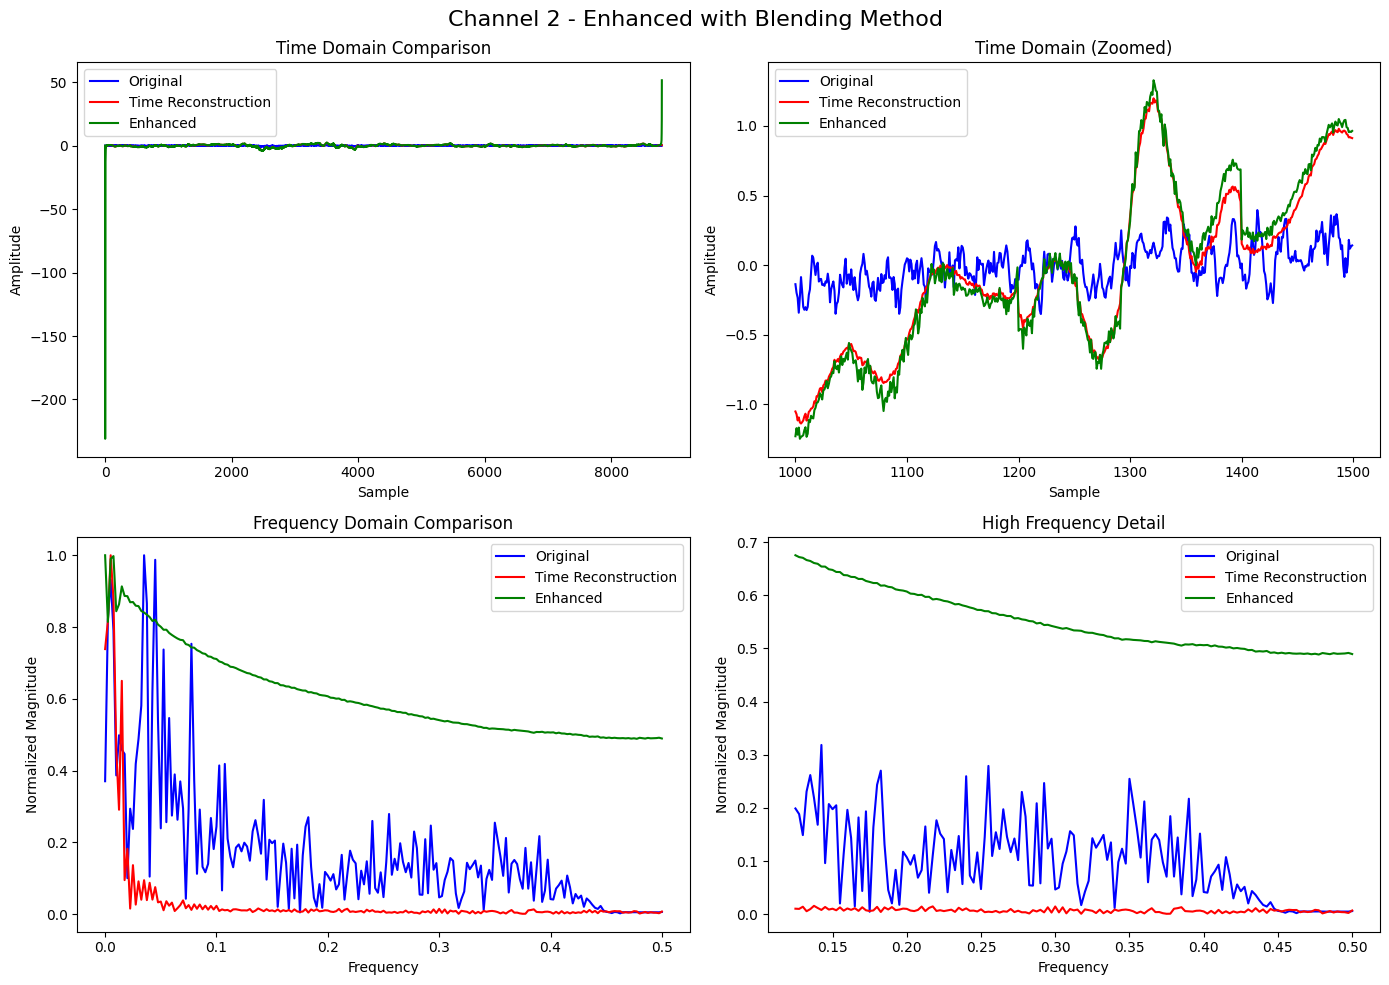


Channel 2 Metrics:
MSE - Raw: 0.000050, Enhanced: 0.000169, Improvement: -240.31%
Correlation - Raw: 0.781668, Enhanced: 0.255167, Improvement: -67.36%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000005, Improvement: -85.20%


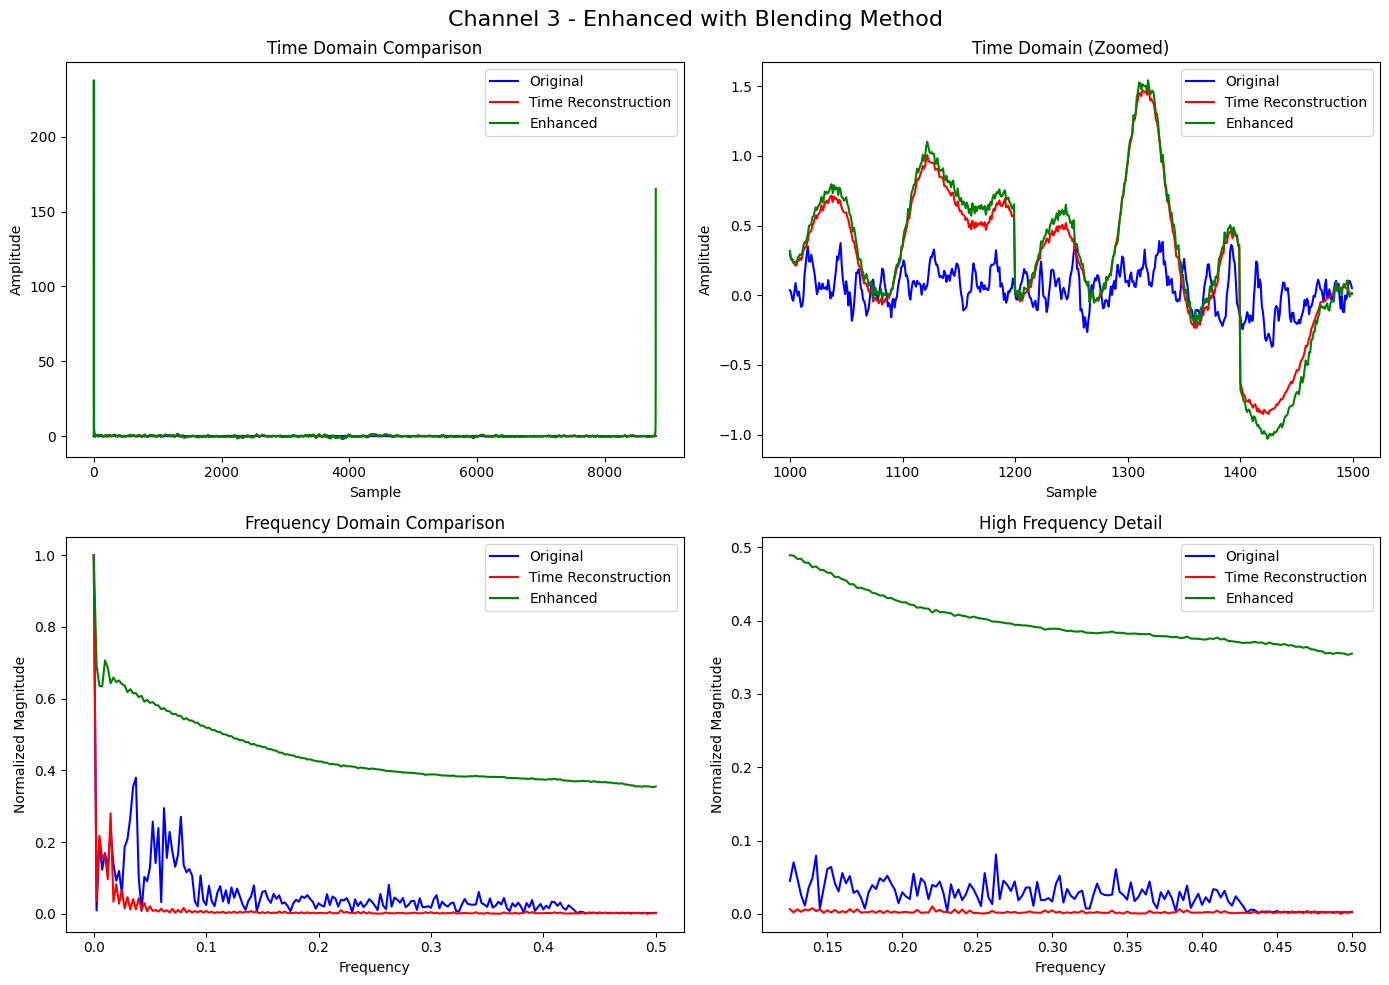


Channel 3 Metrics:
MSE - Raw: 0.000112, Enhanced: 0.000210, Improvement: -87.71%
Correlation - Raw: 0.507035, Enhanced: 0.073348, Improvement: -85.53%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000000, Improvement: 84.82%

Testing enhancement method: highpass


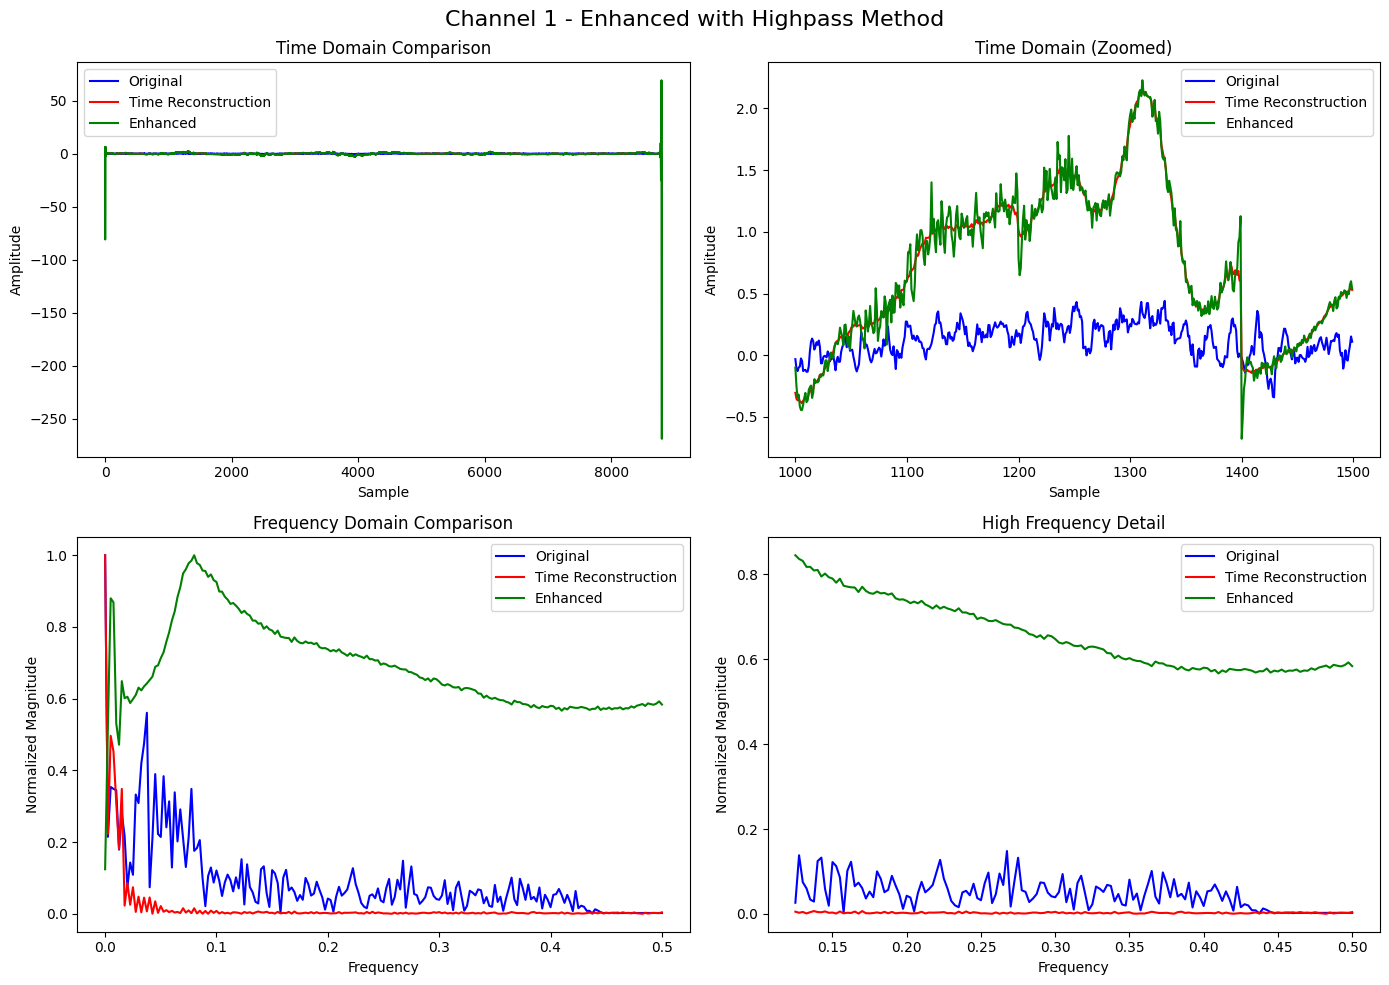


Channel 1 Metrics:
MSE - Raw: 0.000057, Enhanced: 0.000202, Improvement: -253.01%
Correlation - Raw: 0.749179, Enhanced: 0.113275, Improvement: -84.88%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000005, Improvement: -48.20%


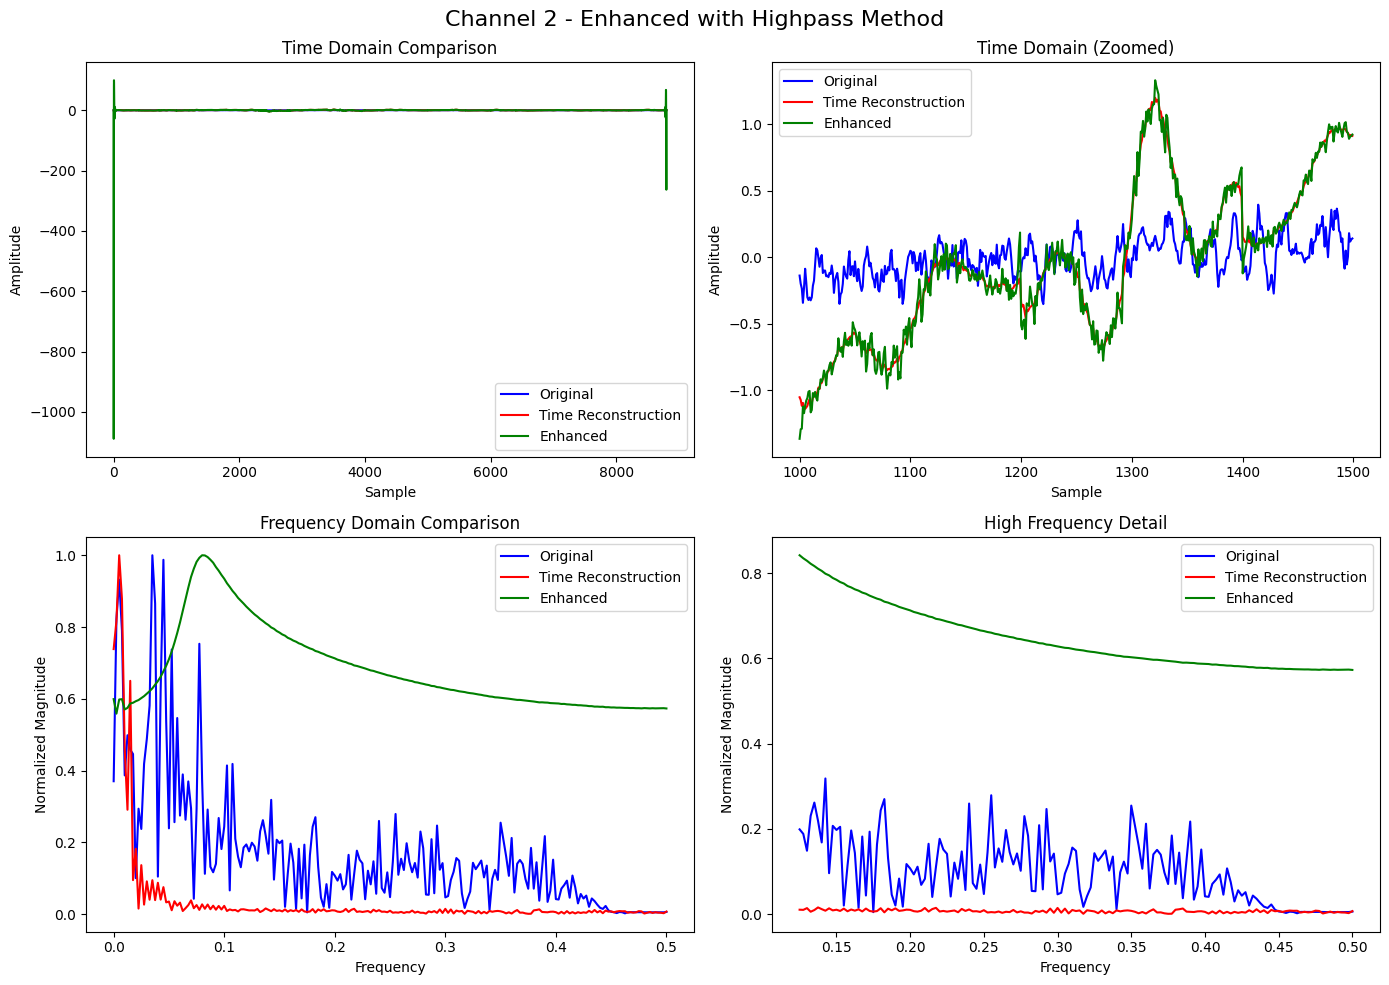


Channel 2 Metrics:
MSE - Raw: 0.000050, Enhanced: 0.000217, Improvement: -335.70%
Correlation - Raw: 0.781668, Enhanced: 0.046608, Improvement: -94.04%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000007, Improvement: -158.55%


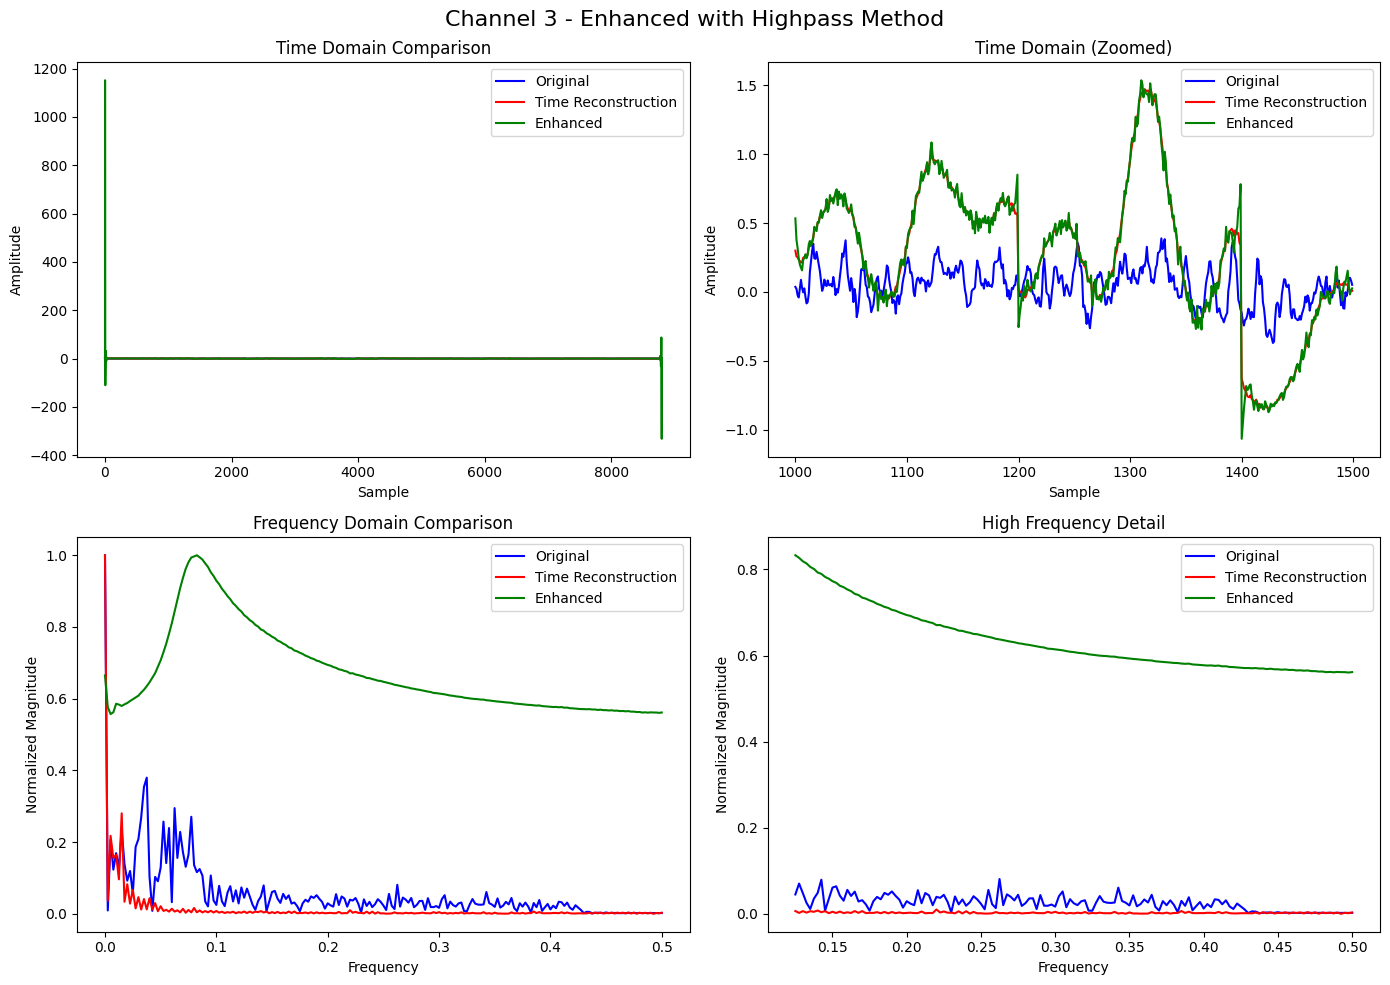


Channel 3 Metrics:
MSE - Raw: 0.000112, Enhanced: 0.000222, Improvement: -98.36%
Correlation - Raw: 0.507035, Enhanced: 0.021692, Improvement: -95.72%
Spectral Distance - Raw: 0.000003, Enhanced: 0.000001, Improvement: 77.07%
Completed analysis for batch 1


In [25]:
"""
Enhanced EEG Reconstruction for NeuroLM VQ Model
This module provides functions to enhance the time domain reconstruction of EEG signals
by incorporating information from the power spectrum reconstruction.
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path


def visualize_enhanced_reconstructions(X, xrec_raw, xrec_freq, num_channels=23, channels_to_show=None,
                                      method='blending', window_length=200, hop_length=None):
    """
    Visualize original, standard, and enhanced reconstructions for selected channels
    
    Args:
        X: Input EEG data [batch, channels, time]
        xrec_raw: Raw domain reconstruction
        xrec_freq: Frequency domain reconstruction
        num_channels: Total number of channels
        channels_to_show: List of channel indices to display (None = all)
        method: Enhancement method ('phase_recovery', 'blending', or 'highpass')
        window_length: Length of each window
        hop_length: Hop size between windows
    """
    if channels_to_show is None:
        channels_to_show = range(min(3, num_channels))  # Show first 3 channels by default
    
    # Convert to numpy
    X_np = X[0].cpu().numpy()  # First batch
    xrec_raw_np = xrec_raw[0].cpu().numpy()
    xrec_freq_np = xrec_freq[0].cpu().numpy()
    
    # Prepare data for enhancement
    enhanced_results = {}
    
    # Compute stop point for reshaping
    stop = X_np.shape[0] - X_np.shape[0] % num_channels
    
    # Process each channel
    for ch_idx in channels_to_show:
        # Extract channel data
        orig_signal = X_np[ch_idx:stop:num_channels, :].flatten()
        raw_recon = xrec_raw_np[ch_idx:stop:num_channels, :].flatten()
        freq_recon = xrec_freq_np[ch_idx:stop:num_channels, :].flatten()
        
        # Convert to PyTorch tensors for the enhancement function
        raw_tensor = torch.tensor(raw_recon).unsqueeze(0)  # Add batch dimension
        freq_tensor = torch.tensor(freq_recon).unsqueeze(0)  # Add batch dimension
        
        # Enhance the reconstruction
        enhanced_tensor = enhance_neurolm_reconstruction(
            raw_tensor, freq_tensor, method=method,
            window_length=window_length, hop_length=hop_length
        )
        
        # Convert back to numpy
        enhanced_signal = enhanced_tensor.cpu().numpy().flatten()
        
        # Store results
        enhanced_results[ch_idx] = {
            'original': orig_signal,
            'raw_recon': raw_recon,
            'enhanced': enhanced_signal
        }
    
    # Visualize each channel separately
    for ch_idx in channels_to_show:
        fig = visualize_enhancement(
            original_signal=enhanced_results[ch_idx]['original'],
            time_recon=enhanced_results[ch_idx]['raw_recon'],
            enhanced_recon=enhanced_results[ch_idx]['enhanced'],
            window_length=window_length
        )
        
        fig.suptitle(f'Channel {ch_idx+1} - Enhanced with {method.capitalize()} Method', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Calculate error metrics
        signals = enhanced_results[ch_idx]
        
        # Normalize signals for fair comparison
        norm_orig = signals['original'] / np.sqrt(np.sum(signals['original']**2))
        norm_raw = signals['raw_recon'] / np.sqrt(np.sum(signals['raw_recon']**2))
        norm_enhanced = signals['enhanced'] / np.sqrt(np.sum(signals['enhanced']**2))
        
        # Calculate error metrics
        raw_mse = np.mean((norm_orig - norm_raw)**2)
        enhanced_mse = np.mean((norm_orig - norm_enhanced)**2)
        
        raw_corr = np.corrcoef(norm_orig, norm_raw)[0, 1]
        enhanced_corr = np.corrcoef(norm_orig, norm_enhanced)[0, 1]
        
        # Calculate spectral distance metrics
        def spectral_distance(sig1, sig2):
            # Compute power spectra
            f1 = np.abs(np.fft.rfft(sig1))**2
            f2 = np.abs(np.fft.rfft(sig2))**2
            # Normalize
            f1 = f1 / np.sum(f1)
            f2 = f2 / np.sum(f2)
            # Compute KL divergence-like measure
            return np.mean((f1 - f2)**2)
        
        raw_spectral_dist = spectral_distance(norm_orig, norm_raw)
        enhanced_spectral_dist = spectral_distance(norm_orig, norm_enhanced)
        
        # Print metrics for this channel
        print(f"\nChannel {ch_idx+1} Metrics:")
        print(f"MSE - Raw: {raw_mse:.6f}, Enhanced: {enhanced_mse:.6f}, Improvement: {(raw_mse-enhanced_mse)/raw_mse*100:.2f}%")
        print(f"Correlation - Raw: {raw_corr:.6f}, Enhanced: {enhanced_corr:.6f}, Improvement: {(enhanced_corr-raw_corr)/raw_corr*100:.2f}%")
        print(f"Spectral Distance - Raw: {raw_spectral_dist:.6f}, Enhanced: {enhanced_spectral_dist:.6f}, Improvement: {(raw_spectral_dist-enhanced_spectral_dist)/raw_spectral_dist*100:.2f}%")


def integrate_enhancement_with_model(model, batch, device, method='blending', window_length=200, hop_length=None):
    """
    Process a batch through model and apply enhancement to the reconstruction
    
    Args:
        model: The trained VQ_Align model
        batch: Batch of EEG data
        device: Device to run inference on
        method: Enhancement method ('phase_recovery', 'blending', or 'highpass')
        window_length: Length of each window
        hop_length: Hop size between windows
        
    Returns:
        X: Original input
        xrec_raw: Raw time-domain reconstruction
        xrec_freq: Frequency domain reconstruction
        xrec_enhanced: Enhanced time-domain reconstruction
    """
    # Process batch through model
    X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
    
    X = X.float().to(device, non_blocking=True)
    Y_freq = Y_freq.float().to(device, non_blocking=True)
    Y_raw = Y_raw.float().to(device, non_blocking=True)
    input_chans = input_chans.to(device, non_blocking=True)
    input_time = input_time.to(device, non_blocking=True)
    input_mask = input_mask.to(device, non_blocking=True)
    
    with torch.no_grad():
        # Get reconstructions from model
        (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
            X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
            return_reconstruction=True
        )
    
    # Enhance the reconstruction
    xrec_enhanced = enhance_neurolm_reconstruction(
        xrec_raw, xrec_freq, method=method,
        window_length=window_length, hop_length=hop_length
    )
    
    return X, xrec_raw, xrec_freq, xrec_enhanced


def analyze_enhanced_reconstructions(model, data_loader, device, num_channels=23, 
                                    methods=['phase_recovery', 'blending', 'highpass'],
                                    window_length=200, hop_length=None, num_batches=1, cache = None):
    """
    Perform comprehensive analysis of enhanced EEG reconstructions
    
    Args:
        model: The trained VQ_Align model
        data_loader: DataLoader with EEG samples
        device: Device to run inference on
        num_channels: Number of EEG channels
        methods: List of enhancement methods to test
        window_length: Length of each window
        hop_length: Hop size between windows
        num_batches: Number of batches to analyze
    """
    model.eval()  # Set model to evaluation mode
    
    for batch_idx, batch in enumerate(data_loader):
        if batch_idx >= num_batches:
            break
        if cache is not None:
            (X, Y_freq, Y_raw, input_chans, input_time, input_mask, (xrec_freq, xrec_raw), encoder_features, log) = cache
        else:
            print(f"\nProcessing batch {batch_idx+1}/{num_batches}")
            
            # Process through model
            X, Y_freq, Y_raw, input_chans, input_time, input_mask = batch
            X = X.float().to(device, non_blocking=True)
            Y_freq = Y_freq.float().to(device, non_blocking=True)
            Y_raw = Y_raw.float().to(device, non_blocking=True)
            input_chans = input_chans.to(device, non_blocking=True)
            input_time = input_time.to(device, non_blocking=True)
            input_mask = input_mask.to(device, non_blocking=True)
            
            with torch.no_grad():
                (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
                    X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
                    return_reconstruction=True
                )
        # Get min values along the last dimension and keep dimensions
        min_values, _ = xrec_freq.min(dim=-1, keepdim=True)
        # Normalize the frequency reconstruction
        xrec_freq = (xrec_freq - min_values)/(1 - min_values)
        # Test each enhancement method
        for method in methods:
            print(f"\nTesting enhancement method: {method}")
            
            # Visualize channel reconstructions with enhanced results
            visualize_enhanced_reconstructions(
                X, xrec_raw, xrec_freq, 
                num_channels=num_channels,
                channels_to_show=range(min(3, num_channels)),  # Show first 3 channels
                method=method,
                window_length=window_length,
                hop_length=hop_length
            )
        
        print(f"Completed analysis for batch {batch_idx+1}")


# Example usage
if __name__ == "__main__":

    # X, Y_freq, Y_raw, input_chans, input_time, input_mask = next(iter(data_loader1))
    # X = X.float().to(device, non_blocking=True)
    # Y_freq = Y_freq.float().to(device, non_blocking=True)
    # Y_raw = Y_raw.float().to(device, non_blocking=True)
    # input_chans = input_chans.to(device, non_blocking=True)
    # input_time = input_time.to(device, non_blocking=True)
    # input_mask = input_mask.to(device, non_blocking=True)
    
    # with torch.no_grad():
    #     (xrec_freq, xrec_raw), encoder_features, log = model.VQ(
    #         X, Y_freq, Y_raw, input_chans, input_time, input_mask, 
    #         return_reconstruction=True
    #     )
    analyze_enhanced_reconstructions(
        model, data_loader1, device, 
        num_channels=23, 
        methods=['phase_recovery', 'blending', 'highpass'],
        cache = (X, Y_freq, Y_raw, input_chans, input_time, input_mask, (xrec_freq, xrec_raw), encoder_features, log)
    )

In [26]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch


def enhance_neurolm_reconstruction(xrec_raw, xrec_freq, method='blending', 
                                window_length=200, hop_length=None, window_func=None, 
                                freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information from PyTorch tensors.
    
    Parameters:
    - xrec_raw: Time-domain reconstruction tensor [batch, channels, time] or [channels, time]
    - xrec_freq: Frequency domain reconstruction tensor [batch, channels, freq] or [channels, freq]
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction tensor with same shape as xrec_raw
    """
    # Determine if we have batch dimension
    has_batch = len(xrec_raw.shape) == 3
    
    # Convert to numpy for processing
    device = xrec_raw.device
    if has_batch:
        batch_size = xrec_raw.shape[0]
        n_channels = xrec_raw.shape[1]
        time_length = xrec_raw.shape[2]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
    else:
        n_channels = xrec_raw.shape[0]
        time_length = xrec_raw.shape[1]
        xrec_raw_np = xrec_raw.cpu().numpy()
        xrec_freq_np = xrec_freq.cpu().numpy()
        batch_size = 1
        # Add batch dimension for consistent processing
        xrec_raw_np = xrec_raw_np.reshape(1, n_channels, time_length)
        xrec_freq_np = xrec_freq_np.reshape(1, n_channels, xrec_freq_np.shape[-1])
    
    # Process each batch and channel separately
    enhanced_recon_np = np.zeros_like(xrec_raw_np)
    
    for b in range(batch_size):
        for c in range(n_channels):
            # Get time domain signal for this channel
            time_signal = xrec_raw_np[b, c]
            
            # Convert power spectra windows to appropriate format
            # We need to reshape the power spectra for this channel
            # The power spectra should be [n_windows, n_freqs]
            freq_length = xrec_freq_np.shape[-1]
            
            # Set hop length if not specified
            if hop_length is None:
                hop_length = window_length // 2
                
            # Calculate number of windows
            n_windows = (time_length - window_length) // hop_length + 1
            
            # Handle the case where power spectra might be arranged differently
            # This depends on how your model outputs the frequency data
            if freq_length == 100:  # As mentioned in prompt, 100 points for power spectrum
                # Create windows from the power spectrum representation
                power_spectra = []
                for i in range(n_windows):
                    # If the model outputs a single power spectrum per channel, 
                    # we'll use it for all windows (replicating)
                    power_spectra.append(xrec_freq_np[b, c])
                power_spectra = np.array(power_spectra)
            else:
                # If power spectra need to be extracted from continuous data
                power_spectra = []
                
                for i in range(0, time_length - window_length + 1, hop_length):
                    window_data = time_signal[i:i+window_length]
                    # Calculate power spectrum for this window
                    window_fft = np.fft.rfft(window_data)
                    window_power = np.abs(window_fft)**2
                    power_spectra.append(window_power)
                
                power_spectra = np.array(power_spectra)
            
            # Use the core function to enhance this channel
            enhanced_channel, _ = enhance_eeg_reconstruction(
                time_signal, power_spectra, method, 
                window_length, hop_length, window_func,
                freq_transition, freq_slope, highpass_cutoff
            )
            
            # Store the enhanced result
            enhanced_recon_np[b, c] = enhanced_channel[:time_length]
    
    # Convert back to tensor and match original shape
    if has_batch:
        enhanced_recon = torch.tensor(enhanced_recon_np, device=device)
    else:
        enhanced_recon = torch.tensor(enhanced_recon_np[0], device=device)
    
    return enhanced_recon


def enhance_eeg_reconstruction(time_recon, power_spectra, method='blending', 
                              window_length=200, hop_length=None, window_func=None, 
                              freq_transition=0.3, freq_slope=5.0, highpass_cutoff=0.3):
    """
    Enhance time-domain EEG reconstruction using power spectra information.
    
    Parameters:
    - time_recon: numpy array of time-domain reconstruction (shape: [n_samples])
    - power_spectra: numpy array of power spectra (shape: [n_windows, n_freqs])
    - method: enhancement method ('phase_recovery', 'blending', or 'highpass')
    - window_length: length of each window (default: 200)
    - hop_length: hop size between windows (default: window_length // 2)
    - window_func: window function to use (default: Hann window)
    - freq_transition: normalized frequency (0-1) for transition point (default: 0.3)
    - freq_slope: steepness of frequency transition (default: 5.0)
    - highpass_cutoff: normalized cutoff frequency for high-pass filter (default: 0.3)
    
    Returns:
    - enhanced_recon: enhanced time-domain reconstruction
    - used_power_spectrum: power spectrum used for enhancement (for visualization)
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    n_freqs = power_spectra.shape[1]
    expected_rfft_length = window_length // 2 + 1  # For real FFT
    
    # Select the appropriate enhancement method
    if method == 'phase_recovery':
        return phase_recovery_enhancement(time_recon, power_spectra, window_length, 
                                         hop_length, window_func)
    elif method == 'blending':
        return freq_blending_enhancement(time_recon, power_spectra, window_length, 
                                        hop_length, window_func, freq_transition, freq_slope)
    elif method == 'highpass':
        return highpass_enhancement(time_recon, power_spectra, window_length, 
                                   hop_length, window_func, highpass_cutoff)
    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'phase_recovery', 'blending', or 'highpass'")


def phase_recovery_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, window_func=None):
    """
    Enhance reconstruction using phase from time domain and magnitude from power spectra.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    # Save a representative power spectrum for visualization
    used_power_spectrum = None
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract phase from time-domain FFT
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Save a representative power spectrum for later visualization (middle window)
        if i == n_windows // 2 and used_power_spectrum is None:
            used_power_spectrum = magnitude_power**2  # Square to get power
        
        # Combine magnitude from power spectrum with phase from time domain
        enhanced_fft = magnitude_power * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon, used_power_spectrum


def freq_blending_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                             window_func=None, freq_transition=0.3, freq_slope=5.0):
    """
    Enhance reconstruction with frequency-dependent blending of original and power spectrum.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    expected_rfft_length = window_length // 2 + 1
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # Create frequency-dependent weights for blending
    freq_indices = np.arange(expected_rfft_length)
    normalized_freqs = freq_indices / (expected_rfft_length - 1)
    
    # Sigmoid weighting: low values for low frequencies, high values for high frequencies
    power_weights = 1.0 / (1.0 + np.exp(-freq_slope * (normalized_freqs - freq_transition)))
    time_weights = 1.0 - power_weights
    
    enhanced_recon = np.zeros_like(time_recon)
    window_sum = np.zeros_like(time_recon)
    
    # Save a representative power spectrum for visualization
    used_power_spectrum = None
    blended_magnitude_visualization = None
    
    for i in range(n_windows):
        start_idx = i * hop_length
        end_idx = start_idx + window_length
        
        # Extract current window
        current_window = time_recon[start_idx:end_idx]
        
        # Apply window function and compute FFT
        windowed_signal = current_window * window_func
        fft_time = np.fft.rfft(windowed_signal)
        
        # Extract magnitude and phase from time-domain FFT
        magnitude_time = np.abs(fft_time)
        phase_time = np.angle(fft_time)
        
        # Handle potential dimension mismatch with power_spectra
        magnitude_power = adjust_power_spectrum(power_spectra[i], phase_time, fft_time)
        
        # Frequency-dependent blending of magnitudes
        blended_magnitude = (time_weights * magnitude_time) + (power_weights * magnitude_power)
        
        # Save a representative power spectrum and blended magnitude for visualization (middle window)
        if i == n_windows // 2 and used_power_spectrum is None:
            used_power_spectrum = magnitude_power**2  # Square to get power
            blended_magnitude_visualization = blended_magnitude**2  # This is what was actually used
        
        # Combine blended magnitude with original phase
        enhanced_fft = blended_magnitude * np.exp(1j * phase_time)
        
        # Convert back to time domain
        enhanced_window = np.fft.irfft(enhanced_fft)
        
        # Apply window and add to output
        enhanced_recon[start_idx:end_idx] += enhanced_window * window_func
        window_sum[start_idx:end_idx] += window_func**2
    
    # Normalize by window overlap
    valid_indices = window_sum > 1e-10
    enhanced_recon[valid_indices] /= window_sum[valid_indices]
    
    return enhanced_recon, blended_magnitude_visualization


def highpass_enhancement(time_recon, power_spectra, window_length=200, hop_length=None, 
                        window_func=None, cutoff_freq=0.3):
    """
    Enhance reconstruction by adding high-frequency components from power spectra.
    
    Returns:
    - enhanced_recon: The enhanced reconstruction
    - used_power_spectrum: The power spectrum used for visualization
    """
    if hop_length is None:
        hop_length = window_length // 2
        
    if window_func is None:
        window_func = signal.windows.hann(window_length, sym=False)
    
    n_windows = len(power_spectra)
    expected_signal_length = hop_length * (n_windows - 1) + window_length
    
    # Ensure time_recon is long enough
    if len(time_recon) < expected_signal_length:
        time_recon = np.pad(time_recon, (0, expected_signal_length - len(time_recon)))
    
    # First, reconstruct signal from power spectra using phase from time domain
    power_recon, used_power_spectrum = phase_recovery_enhancement(time_recon, power_spectra, window_length, hop_length, window_func)
    
    # Design high-pass filter
    nyquist = 0.5  # Normalized Nyquist frequency
    cutoff = cutoff_freq * nyquist
    b, a = signal.butter(5, cutoff, btype='high', analog=False)
    
    # Apply high-pass filter to power-based reconstruction
    highpass_power_recon = signal.filtfilt(b, a, power_recon)
    
    # Combine original time reconstruction with high-pass filtered power reconstruction
    enhanced_recon = time_recon + highpass_power_recon
    
    # Create a visualization of the high-pass spectrum
    if used_power_spectrum is not None:
        # Create a frequency axis for visualization
        freq_indices = np.arange(len(used_power_spectrum))
        normalized_freqs = freq_indices / (len(used_power_spectrum) - 1)
        
        # Create high-pass mask similar to our filter
        highpass_mask = np.ones_like(normalized_freqs)
        transition_idx = int(cutoff_freq * len(normalized_freqs))
        highpass_mask[:transition_idx] = 0
        
        # Smoothen the transition
        transition_width = int(0.05 * len(normalized_freqs))
        for i in range(transition_idx - transition_width, transition_idx + transition_width):
            if 0 <= i < len(highpass_mask):
                x = (i - (transition_idx - transition_width)) / (2 * transition_width)
                highpass_mask[i] = 0.5 * (1 - np.cos(np.pi * x))
        
        # Apply the high-pass mask to the power spectrum for visualization
        highpass_spectrum = used_power_spectrum * highpass_mask
        
        return enhanced_recon, highpass_spectrum
    
    return enhanced_recon, used_power_spectrum


def adjust_power_spectrum(power_spectrum, phase, fft_time):
    """
    Adjust power spectrum to match expected dimensions for rfft output.
    """
    expected_length = len(phase)
    
    if len(power_spectrum) != expected_length:
        adjusted_power = np.zeros(expected_length)
        
        if len(power_spectrum) == expected_length - 1:
            # Missing DC component
            adjusted_power[1:] = power_spectrum
            adjusted_power[0] = np.abs(fft_time[0])**2  # Use DC from time domain
        else:
            # Missing highest frequency bin or different size
            min_len = min(len(power_spectrum), expected_length)
            adjusted_power[:min_len] = power_spectrum[:min_len]
            
            # Fill remaining with time-domain data if needed
            if expected_length > min_len:
                adjusted_power[min_len:] = np.abs(fft_time[min_len:])**2
    else:
        adjusted_power = power_spectrum
    
    # Convert power to magnitude
    return np.sqrt(adjusted_power)


def visualize_enhancement(original_signal=None, time_recon=None, enhanced_recon=None, 
                         power_spectrum=None, sampling_rate=None, window_length=200):
    """
    Visualize the original, reconstructed, and enhanced signals in time and frequency domains.
    
    Parameters:
    - original_signal: Original EEG signal (optional)
    - time_recon: Time domain reconstruction (optional)
    - enhanced_recon: Enhanced reconstruction (optional)
    - power_spectrum: Power spectrum used in enhancement (optional)
    - sampling_rate: Sampling rate for time axis (optional)
    - window_length: Length of each window (default: 200)
    
    Returns:
    - fig: Matplotlib figure object
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Determine signal lengths and time axis
    signals = [s for s in [original_signal, time_recon, enhanced_recon] if s is not None]
    min_length = min(len(s) for s in signals)
    
    time_axis = np.arange(min_length)
    if sampling_rate:
        time_axis = time_axis / sampling_rate
        time_label = 'Time (s)'
    else:
        time_label = 'Sample'
    
    # Time domain plot
    ax = axes[0, 0]
    if original_signal is not None:
        ax.plot(time_axis, original_signal[:min_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(time_axis, time_recon[:min_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(time_axis, enhanced_recon[:min_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain Comparison')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Zoomed time domain (show detail of high frequency differences)
    ax = axes[0, 1]
    zoom_start = min(1000, min_length // 2)
    zoom_length = min(500, min_length // 4)
    zoom_time = time_axis[zoom_start:zoom_start+zoom_length]
    
    if original_signal is not None:
        ax.plot(zoom_time, original_signal[zoom_start:zoom_start+zoom_length], 'b-', label='Original')
    if time_recon is not None:
        ax.plot(zoom_time, time_recon[zoom_start:zoom_start+zoom_length], 'r-', label='Time Reconstruction')
    if enhanced_recon is not None:
        ax.plot(zoom_time, enhanced_recon[zoom_start:zoom_start+zoom_length], 'g-', label='Enhanced')
    
    ax.set_title('Time Domain (Zoomed)')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Frequency domain plot
    ax = axes[1, 0]
    n_fft = window_length * 2
    
    # Calculate FFT for all signals
    def calculate_fft(signal):
        fft_result = np.abs(np.fft.rfft(signal[:min_length], n=n_fft))
        # Normalize for better comparison
        return fft_result / np.max(fft_result) if np.max(fft_result) > 0 else fft_result
    
    freq_axis = np.fft.rfftfreq(n_fft, d=1.0/sampling_rate if sampling_rate else 1.0)
    
    if original_signal is not None:
        original_fft = calculate_fft(original_signal)
        ax.plot(freq_axis, original_fft, 'b-', label='Original')
    
    if time_recon is not None:
        time_recon_fft = calculate_fft(time_recon)
        ax.plot(freq_axis, time_recon_fft, 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        enhanced_fft = calculate_fft(enhanced_recon)
        ax.plot(freq_axis, enhanced_fft, 'g-', label='Enhanced')
    
    # Add power spectrum used in enhancement if provided
    if power_spectrum is not None:
        # Ensure power spectrum length matches freq_axis
        if len(power_spectrum) != len(freq_axis):
            # Resample or pad/trim as needed
            if len(power_spectrum) > len(freq_axis):
                power_spectrum = power_spectrum[:len(freq_axis)]
            else:
                power_spectrum = np.pad(power_spectrum, (0, len(freq_axis) - len(power_spectrum)))
        
        # Normalize for better comparison
        power_spectrum_norm = power_spectrum / np.max(power_spectrum) if np.max(power_spectrum) > 0 else power_spectrum
        ax.plot(freq_axis, power_spectrum_norm, 'm--', label='Power Spectrum', linewidth=1.5)
    
    ax.set_title('Frequency Domain Comparison')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    # High frequency zoom
    ax = axes[1, 1]
    # Focus on higher frequencies (second half of the spectrum)
    high_freq_start = len(freq_axis) // 4
    
    if original_signal is not None:
        ax.plot(freq_axis[high_freq_start:], original_fft[high_freq_start:], 'b-', label='Original')
    
    if time_recon is not None:
        ax.plot(freq_axis[high_freq_start:], time_recon_fft[high_freq_start:], 'r-', label='Time Reconstruction')
    
    if enhanced_recon is not None:
        ax.plot(freq_axis[high_freq_start:], enhanced_fft[high_freq_start:], 'g-', label='Enhanced')
    
    # Add power spectrum to high frequency zoom plot
    if power_spectrum is not None:
        ax.plot(freq_axis[high_freq_start:], power_spectrum_norm[high_freq_start:], 'm--', 
                label='Power Spectrum', linewidth=1.5)
    
    ax.set_title('High Frequency Detail')
    ax.set_xlabel('Frequency' + (' (Hz)' if sampling_rate else ''))
    ax.set_ylabel('Normalized Magnitude')
    ax.legend()
    
    plt.tight_layout()
    return fig